In [22]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!cp -r /content/drive/MyDrive/vq-vae-2/data .
!cp -r /content/drive/MyDrive/vq-vae-2/distributed .

In [24]:
# Import required libraries
import pandas as pd
from torch.utils import data
import numpy.random as npr
import numpy as np
from os import path
import warnings
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import datetime
import time
from scipy.stats import loguniform
from torch import nn, optim
import copy
from torchvision import transforms
from torch.optim import lr_scheduler
import distributed as dist_fn
from torch.nn import functional as F
from sklearn import metrics as mt
import pickle
from scipy import integrate
from matplotlib import cm
from collections import namedtuple

In [25]:
# Configure inline matplotlib backend
%matplotlib inline

In [26]:
# Ignore all warnings
warnings.filterwarnings('ignore')

In [27]:
# Select GPU device
device = 'cuda'

In [28]:
class PatientDataset(data.Dataset):
    def __init__(self, data_path, complete=[], uninformative=[], categorical=[], category_total={}, transform=None, max_size=None, min_length=None, split_threshold=1,  seed=42):
        # Read dataset and initialize properties and transform
        self.dataset = pd.read_csv(data_path)
        self.complete = complete
        self.uninformative = uninformative
        self.categorical = categorical
        self.transform = transform

        # Convert date feature and sort dataset by date
        self.dataset['date'] = pd.to_datetime(self.dataset.date, format='%Y-%m-%d')
        self.dataset = self.dataset.sort_values(by='date')

        # Define patient indices
        self.indices = pd.unique(self.dataset.id).tolist()

        # Split and merge patient non-consecutive sequences
        new_dataset = []
        max_index = max(self.indices) + 1
        for index in self.indices:
            sample = self.dataset[self.dataset.id == index]
            sample_dates = sample.date
            sample_dates = (sample_dates - sample_dates.iloc[0]).dt.days
            samples = np.split(sample, np.flatnonzero(np.diff(sample_dates) > split_threshold) + 1)

            # Fill missing dates in sample
            for pointer, sample in enumerate(samples):
                new_sample = pd.DataFrame()
                sample_dates = sample.date
                start_date = sample_dates.iloc[0]
                end_date = sample_dates.iloc[len(sample)-1]
                new_sample['date'] = pd.date_range(start_date, end_date)
                new_sample['is_weekend'] = (new_sample.date.dt.dayofweek > 4).astype(np.uint8)
                remaining = list(set(complete) - set(('id', 'date', 'is_weekend')))
                if remaining:
                    new_sample[remaining] = sample[remaining].mode().iloc[0]
                sample = sample.merge(new_sample, 'outer').sort_values(by='date')
                sample['id'] = max_index + pointer
                new_dataset.append(sample)
            max_index += pointer + 1
        self.dataset = pd.concat(new_dataset)
        self.indices = pd.unique(self.dataset.id).tolist()

        # One-hot encode categorical features
        self.redundant = []
        binary = 0
        for column in self.categorical:
            # Add extra missing categories
            values = sorted(pd.unique(self.dataset[column]))
            if column in category_total:
                total = category_total[column] + 1
                values = [value for value in np.arange(0, total)]
                categories = pd.DataFrame([[value] for value in values], columns=[column])
                self.dataset = pd.concat((self.dataset, categories))

            # Compute total binary features
            dummies = [f'{column}_{value:.1f}' for value in values if not np.isnan(value)][1:]
            self.redundant.extend(dummies[1:])
            binary += len(dummies)

            # Produce one-hot encode dummies and fill missing values
            self.dataset = pd.get_dummies(self.dataset, columns=[column], dummy_na=True, drop_first=True)
            dummy_nan = f'{column}_nan'
            self.dataset.loc[self.dataset[dummy_nan] == 1, dummies] = np.nan
            self.dataset = self.dataset.drop(dummy_nan, axis=1)

            # Remove extra missing rows
            if column in category_total:
                self.dataset = self.dataset.iloc[:-total, :]

        # Remove all samples with length below min_length
        removed = []
        offset = 0
        if min_length:
            for order, index in enumerate(self.indices.copy()):
                data = self.dataset[self.dataset.id == index]
                if data.shape[0] < min_length:
                    removed.append(index)
                    self.indices.pop(order - offset)
                    offset += 1
            self.dataset = self.dataset[~self.dataset.id.isin(removed)]

        # Trim dataset to max_size samples
        if max_size:
            indices = npr.RandomState(seed=seed).permutation(self.indices)
            self.indices = indices[:max_size].tolist()
            self.dataset = self.dataset[self.dataset.id.isin(self.indices)]

        # Compute mean and standard deviation
        self.mean = self.dataset.mean()
        self.std = self.dataset.std()
        self.std = self.std.drop('date')

        # Correct statistics for categorical features
        self.mean.iloc[-binary:] = 0
        self.std.iloc[-binary:] = 1
        uninformative = [column for column in self.uninformative + self.categorical if column in self.mean.index]
        self.mean = self.mean.drop(uninformative).tolist()
        self.std = self.std.drop(uninformative).tolist()

    def __len__(self):
        # Return number of patient samples
        return len(self.indices)

    def __getitem__(self, index):
        # Get patient sample for index
        index = self.indices[index]
        data = self.dataset[self.dataset.id == index].reset_index(drop=True)

        # Remove uninformative columns
        data = data.drop(self.uninformative, axis=1)

        # Extract missingness masks from sample
        mask_data = 1 - data.isna()
        remove = [target for query in self.complete + self.redundant for target in mask_data.columns if target.startswith(query)]
        mask = mask_data.drop(remove, axis=1)

        # Convert data and mask to numpy arrays
        data = data.to_numpy()
        mask_data = mask_data.to_numpy(dtype=np.uint8)
        mask = mask.to_numpy(dtype=np.uint8)

        # Construct and transform sample
        sample = {'data': data, 'mask_data': mask_data, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)

        return sample

Mean: [50955.2105653052, 27433.9857453667, -5123.18961063531, 32621.383472380276, 602.7035919934192, 38.48776231040931, 2.8948504520291527, 5731.903144024685, 3648.0873794312574, 2415.0100200292027, -9.997325011145787, 75.20326390276465, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Standard deviation: [251270.2688167236, 8987.99125233997, 8138.900804352546, 10544.186537718308, 507.22543910565224, 144.83517102089576, 2.5944850202630283, 5568.329314902533, 15069.229870664667, 5691.678800183191, 145.34778392698888, 21.88378439970037, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Execution time: 142.20075106620789
Min length: 280
Max length: 2653
Missing proportions:
Location distance:       0.6621
Sleep end time:          0.6662
Sleep start:             0.6662
Sleep duration:          0.6650
Emotions valence:        0.

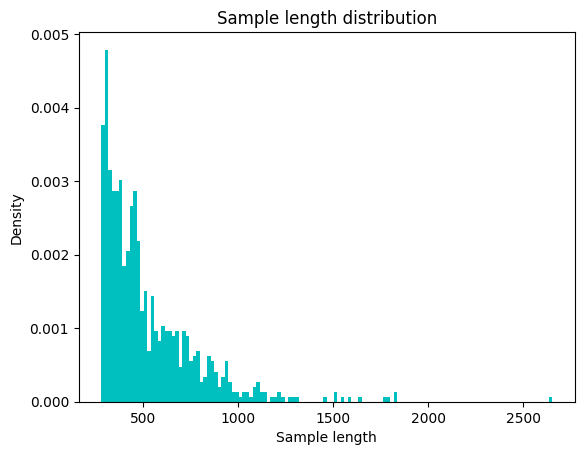

In [29]:
# Define data locations
data_folder = 'data'
train_file = 'train.csv'
val_file = 'val.csv'
test_file = 'test.csv'

# Define study cohort
cohort = 'new'

if cohort == 'old':
    # Define data location
    train_path = path.join(data_folder, cohort, train_file)
    val_path = path.join(data_folder, cohort, val_file)
    test_path = path.join(data_folder, cohort, test_file)

    # Define complete, categorical and uninformative features
    complete = ['id', 'date', 'is_weekend']
    uninformative = ['id', 'date']
    categorical = ['is_weekend', 'practiced_sport', 'valence', 'arousal', 'AvsV']
elif cohort == 'new':
    # Define data location
    train_path = path.join(data_folder, cohort, train_file)
    val_path = path.join(data_folder, cohort, val_file)
    test_path = path.join(data_folder, cohort, test_file)

    # Define complete, categorical and uninformative features
    complete = ['id', 'date', 'cohort', 'is_weekend']
    uninformative = ['id', 'date']
    categorical = ['cohort', 'emotions_valence', 'is_weekend']

# Define wrapping length and scale
min_scale = 1/4
max_scale = 4
window_length = 32

# Define dataset parameters
max_size = 1024
slice_length = 128
extra_length = int(np.ceil((1-min_scale) * window_length))
min_length = 2*slice_length + extra_length
split_threshold = 1
category_total = {'cohort': 30}

# Load example dataset
start = time.time()
dataset = PatientDataset(train_path,
                         complete=complete, uninformative=uninformative, categorical=categorical,
                         max_size=max_size, min_length=min_length, split_threshold=split_threshold,
                         category_total=category_total)
train_mean = dataset.mean
train_std = dataset.std
print(f'Mean: {train_mean}')
print(f'Standard deviation: {train_std}')
print(f'Execution time: {time.time()-start}')

# Get dataset statistics
data_lengths = []
num_features, _ = dataset[0]['mask'].shape
feature_totals = np.array(num_features)
for sample in dataset:
    sample_mask = sample['mask']
    data_length = sample_mask.shape[0]
    data_lengths.append(data_length)
    feature_totals = feature_totals + sample_mask.sum(0)

# Compute dataset min and max sample lengths
max_length = max(data_lengths)
print(f'Min length: {min(data_lengths)}')
print(f'Max length: {max(data_lengths)}')

# Compute feature binary proportions
feature_names = ['Location distance', 'Sleep end time', 'Sleep start', 'Sleep duration', 'Emotions valence',
                 'Location time at home', 'Location time at work', 'Location clusters count', 'Steps total',
                 'Activity walking', 'Activity vehicle', 'Emotions ratio', 'Heart rate mean']
feature_proportions = 1 - feature_totals / sum(data_lengths)
print('Missing proportions:')
for index, proportion in enumerate(feature_proportions):
    print(f'{(feature_names[index] + ":").ljust(24)} {proportion:.4f}')

# Plot distribution of sample lengths
bins = 128
plt.hist(data_lengths, bins, density=True, color='c')
plt.title('Sample length distribution')
plt.xlabel('Sample length')
plt.ylabel('Density');

In [30]:
class Wrap:
    def __init__(self, min_scale, max_scale, window_length):
        # Initialize wrapping parameters
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.window_length = window_length

    def __call__(self, sample):
        # Get patient sample
        data, mask_data, mask = sample['data'], sample['mask_data'], sample['mask']

        # Get current data length
        length = data.shape[0]

        # Sample random starting and ending point from slice length
        if length > self.window_length:
            start = npr.randint(0, length - self.window_length)
        else:
            start = 0
        end = start + self.window_length

        # Slice patient sample
        data_mid = data[start:end, :]
        mask_data_mid = mask_data[start:end, :]
        mask_mid = mask[start:end, :]

        # Input data missing values with zeros
        data_mid[mask_data_mid == 0] = 0

        # Compute new length from sampled resize factor
        resize_factor = loguniform.rvs(self.min_scale, self.max_scale)
        channels = data_mid.shape[1]
        channels_mask = mask_mid.shape[1]
        new_length = resize_factor * self.window_length

        # Define sample line spaces
        length_space = np.arange(0, new_length, resize_factor)
        channels_space = np.arange(channels)
        channels_mask_space = np.arange(channels_mask)

        # Define interpolation grids
        channels_grid, length_grid = np.meshgrid(channels_space, length_space)
        channels_mask_grid, length_mask_grid = np.meshgrid(channels_mask_space, length_space)
        channels_grid = channels_grid.reshape(-1, 1)
        channels_mask_grid = channels_mask_grid.reshape(-1, 1)
        length_grid = length_grid.reshape(-1, 1)
        length_mask_grid = length_mask_grid.reshape(-1, 1)

        # Organize grids into coordinates
        coordinates = np.hstack((length_grid, channels_grid))
        coordinates_mask = np.hstack((length_mask_grid, channels_mask_grid))

        # Define sample interpolators
        interpolator_data = interpolate.NearestNDInterpolator(
            coordinates, data_mid.reshape(-1))
        interpolator_mask_data = interpolate.NearestNDInterpolator(
            coordinates, mask_data_mid.reshape(-1))
        interpolator_mask = interpolate.NearestNDInterpolator(
            coordinates_mask, mask_mid.reshape(-1))

        # Redefine interpolation grids
        new_length_space = np.arange(new_length)
        channels_grid, new_length_grid = np.meshgrid(channels_space, new_length_space)
        channels_mask_grid, new_length_mask_grid = np.meshgrid(channels_mask_space, new_length_space)

        # Resize patient sample
        data_mid = interpolator_data(new_length_grid, channels_grid)
        mask_data_mid = interpolator_mask_data(new_length_grid, channels_grid)
        mask_mid = interpolator_mask(new_length_mask_grid, channels_mask_grid)

        # Input data zeros with missing values
        data_mid[mask_data_mid == 0] = np.nan

        # Stack original and resized windows
        data = np.vstack((data[:start, :], data_mid, data[end:, :]))
        mask_data = np.vstack((mask_data[:start, :], mask_data_mid, mask_data[end:, :]))
        mask = np.vstack((mask[:start, :], mask_mid, mask[end:, :]))

        sample = {'data': data, 'mask_data': mask_data, 'mask': mask}
        return sample

Original shape: (447, 13)
Wrapped shape: (446, 13)


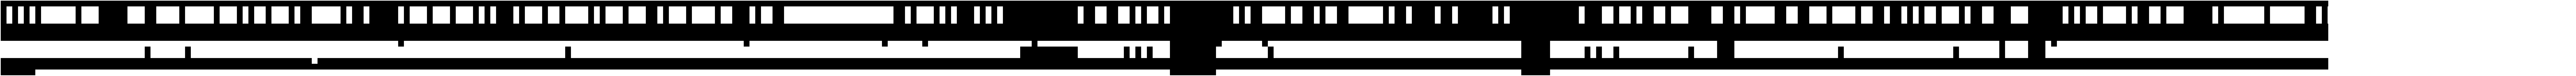

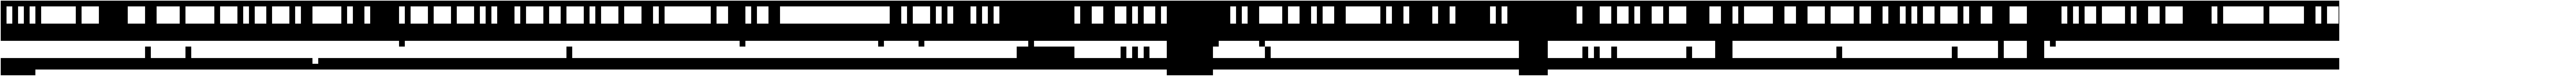

In [31]:
# Plot original sample mask
sample = dataset[0]
sample_mask = sample['mask']
print(f'Original shape: {sample_mask.shape}')
plt.figure(figsize=sample_mask.shape)
plt.imshow(sample_mask.T, cmap='gray')
plt.axis('off')

# Wrap sample
wrap = Wrap(min_scale, max_scale, window_length)
wrapped_sample = wrap(sample)

# Plot wrapped sample mask
wrapped_mask = wrapped_sample['mask']
print(f'Wrapped shape: {wrapped_mask.shape}')
plt.figure(figsize=wrapped_mask.shape)
plt.imshow(wrapped_mask.T, cmap='gray')
plt.axis('off');

In [32]:
class RandomCrop:
    def __init__(self, slice_length):
        # Initialize slice length
        self.slice_length = slice_length

    def __call__(self, sample):
        # Get patient sample
        data, mask_data, mask = sample['data'], sample['mask_data'], sample['mask']

        # Get current data length
        length = data.shape[0]

        # Sample random starting and ending point from slice length
        double_slice_length = 2 * self.slice_length
        if length > double_slice_length:
            start = npr.randint(0, length - double_slice_length)
        else:
            start = 0
        mid = start + self.slice_length
        end = mid + self.slice_length

        # Slice patient sample
        input_data = data[start:mid, :]
        future_data = data[mid:end, :]
        input_mask_data = mask_data[start:mid, :]
        future_mask_data = mask_data[mid:end, :]
        input_mask = mask[start:mid, :]
        future_mask = mask[mid:end, :]

        sample = {'input': {'data': input_data, 'mask_data': input_mask_data, 'mask': input_mask},
                  'future': {'data': future_data, 'mask_data': future_mask_data, 'mask': future_mask}}
        return sample

Wrapped shape: (446, 13)
Cropped shape: (128, 13)


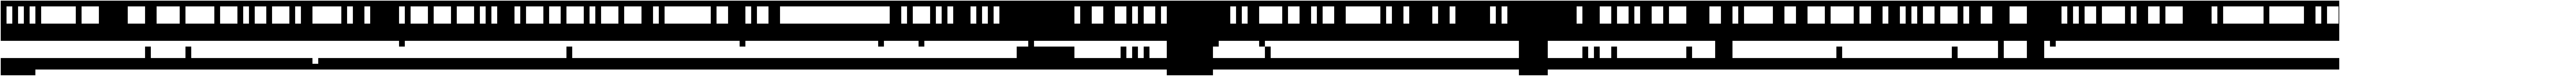

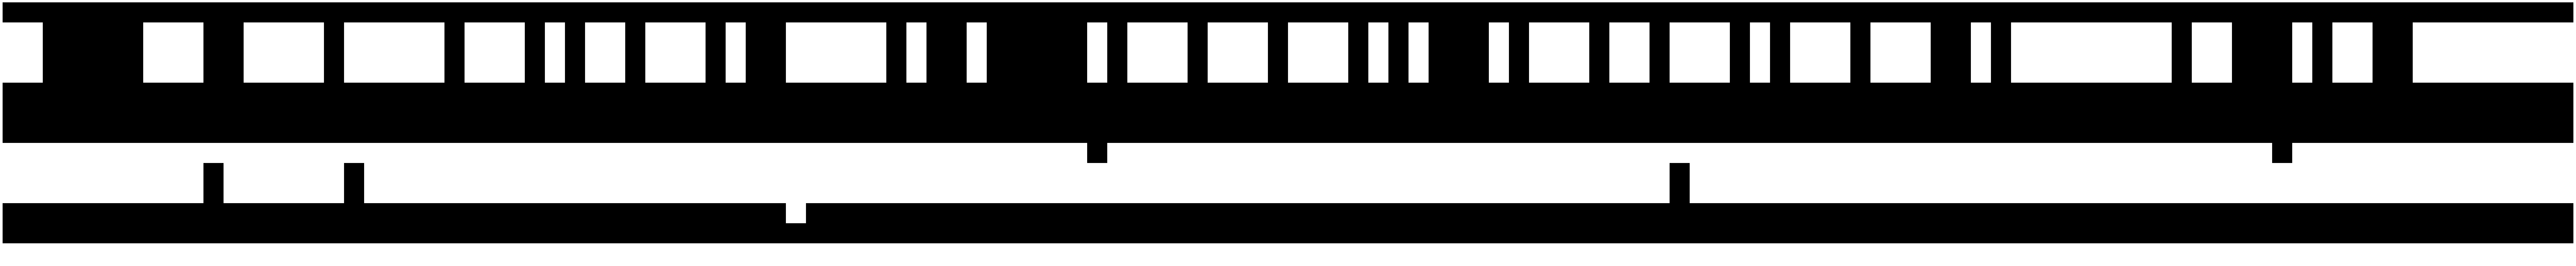

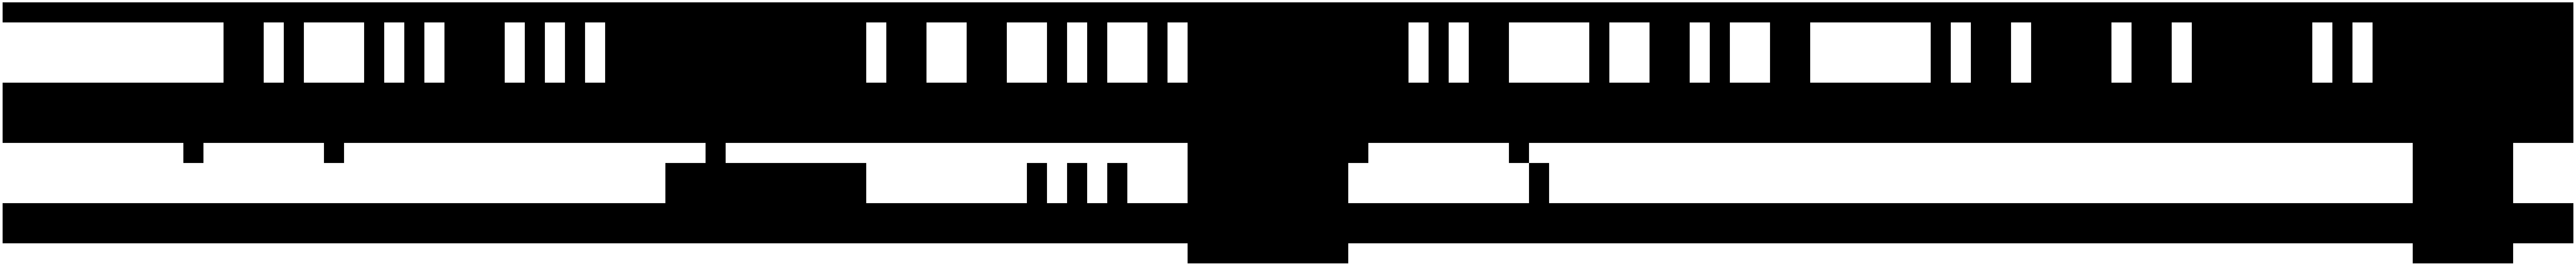

In [33]:
# Plot wrapped sample mask
wrapped_mask = wrapped_sample['mask']
print(f'Wrapped shape: {wrapped_mask.shape}')
plt.figure(figsize=wrapped_mask.shape)
plt.imshow(wrapped_mask.T, cmap='gray')
plt.axis('off');

# Random crop wrapped sample
crop = RandomCrop(slice_length)
cropped_sample = crop(wrapped_sample)

# Plot cropped sample mask
input_cropped_mask = cropped_sample['input']['mask']
future_cropped_mask = cropped_sample['future']['mask']
print(f'Cropped shape: {input_cropped_mask.shape}')
assert input_cropped_mask.shape == future_cropped_mask.shape
plt.figure(figsize=input_cropped_mask.shape)
plt.imshow(input_cropped_mask.T, cmap='gray')
plt.axis('off')
plt.figure(figsize=future_cropped_mask.shape)
plt.imshow(future_cropped_mask.T, cmap='gray')
plt.axis('off');

In [34]:
class Tensor:
    def __call__(self, sample):
        # Copy sample object
        sample = copy.deepcopy(sample)

        for group in sample:
            sample_group = sample[group]
            for category in sample_group:
                # Get category data
                data = sample_group[category]

                # Permute axes
                data = data.transpose((1, 0))

                # Convert numpy array to torch tensor
                data = torch.from_numpy(data)

                # Store data in sample
                sample_group[category] = data

        return sample

In [35]:
# Describe cropped sample mask
cropped_mask = cropped_sample['input']['mask']
print(f'Masked shape: {cropped_mask.shape}')

# Convert to tensor
tensor = Tensor()
tensor_sample = tensor(cropped_sample)

# Describe tensor cropped sample mask
tensor_mask = tensor_sample['input']['mask']
print(f'Tensor size: {tensor_mask.size()}')

Masked shape: (128, 13)
Tensor size: torch.Size([13, 128])


In [36]:
# Define wrapping length and scale
min_scale = 2 - 1e-10
max_scale = 2
window_length = 32

# Define dataset parameters
slice_length = 128
double_slice_length = 2 * slice_length
extra_length = int(np.ceil((1-min_scale) * window_length))
min_length_train = double_slice_length + extra_length
min_length_test = double_slice_length
split_threshold = 1

# Define dataset transforms
wrap = Wrap(min_scale, max_scale, window_length)
crop = RandomCrop(slice_length)
tensor = Tensor()
train_transform = transforms.Compose([wrap, crop, tensor])
test_transform = transforms.Compose([crop, tensor])

# Define train, validation, and test datasets
train_dataset = PatientDataset(train_path,
                               complete=complete, uninformative=uninformative, categorical=categorical,
                               transform=train_transform,
                               min_length=min_length_train, split_threshold=split_threshold,
                               category_total=category_total)
val_dataset = PatientDataset(val_path,
                             complete=complete, uninformative=uninformative, categorical=categorical,
                             transform=test_transform,
                             min_length=min_length_test, split_threshold=split_threshold,
                             category_total=category_total)
test_dataset = PatientDataset(test_path,
                              complete=complete, uninformative=uninformative, categorical=categorical,
                              transform=test_transform,
                              min_length=min_length_test, split_threshold=split_threshold,
                              category_total=category_total)
print(f'Train size: {len(train_dataset)}')
print(f'Validation size: {len(val_dataset)}')
print(f'Test size {len(test_dataset)}')

# Define loader parameters
train_batch_size = 256
test_batch_size = 64
num_workers = 10

# Define train, validation, and test loaders
train_loader = data.DataLoader(train_dataset, batch_size=train_batch_size,
                               shuffle=True, num_workers=num_workers)
val_loader = data.DataLoader(val_dataset, batch_size=test_batch_size,
                             shuffle=False, num_workers=num_workers)
test_loader = data.DataLoader(test_dataset, batch_size=test_batch_size,
                              shuffle=False, num_workers=num_workers)
loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

Train size: 1051
Validation size: 102
Test size 101


In [37]:
class Quantizer(nn.Module):
    def __init__(self, embed_dim, num_embed, decay, threshold, eps=1e-5):
        super().__init__()

        # Initialize quantizer parameters
        self.embed_dim = embed_dim
        self.num_embed = num_embed
        self.decay = decay
        self.threshold = threshold
        self.eps = eps

        # Initialize embedding properties
        embed = torch.randn(embed_dim, num_embed) #/ 100
        #print(embed)
        self.register_buffer('embed', embed)
        self.register_buffer('cluster_size', torch.zeros(num_embed))
        self.register_buffer('embed_mean', embed.clone())

    def forward(self, input):
        # Flatten batch inputs (encoder outputs)
        flatten = input.reshape(-1, self.embed_dim)

        # Compute l2 norm between batch inputs and embeddings
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True))

        # One-hot encode inimum distance indices
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.num_embed).type(flatten.dtype)

        # Look up embeddings for indices
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        # Update embeddings durring training
        if self.training:
            # Compute indices matches per embedding
            embed_onehot_sum = embed_onehot.sum(0)

            # Compute input sum per embedding
            embed_sum = flatten.transpose(0, 1) @ embed_onehot

            dist_fn.all_reduce(embed_onehot_sum)
            dist_fn.all_reduce(embed_sum)

            # Update moving averages: total count and representation sum per embedding
            self.cluster_size.data.mul_(self.decay).add_(
                embed_onehot_sum, alpha=1-self.decay)
            self.embed_mean.data.mul_(self.decay).add_(embed_sum, alpha=1-self.decay)

            # Compute stable total count
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.num_embed * self.eps) * n)

            # Compute representation mean per embedding
            pool = torch.tile(flatten, (np.ceil(self.num_embed / flatten.size(0)).astype('int'), 1))
            rand_embed = pool[npr.permutation(pool.size(0))[:self.num_embed], :].transpose(0, 1)
            usage = (self.cluster_size >= self.threshold).float()
            embed_normalized = self.embed_mean / cluster_size.unsqueeze(0)
            embed = usage * embed_normalized + (1 - usage) * rand_embed
            self.embed.data.copy_(embed)

        # Compute average distance between quantization and input
        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()
        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        # Look up embeddings for indices
        return F.embedding(embed_id, self.embed.transpose(0, 1))

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers,
                 conv_dims, kernel_sizes, strides, p):
        super().__init__()

        # Initialize model parameters
        self.num_layers = num_layers

        # Define convolutional layers
        self.conv1 = nn.Conv1d(input_dim, conv_dims[0], kernel_sizes[0], strides[0])
        if num_layers == 2:
            self.conv2 = nn.Conv1d(conv_dims[0], output_dim, kernel_sizes[1], strides[1])
        elif num_layers == 4:
            self.conv2 = nn.Conv1d(conv_dims[0], conv_dims[1], kernel_sizes[1], strides[1])
            self.conv3 = nn.Conv1d(conv_dims[1], conv_dims[2], kernel_sizes[2], strides[2])
            self.conv4 = nn.Conv1d(conv_dims[2], output_dim, kernel_sizes[3], strides[3])

        # Define activation layer and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

    def forward(self, input):
        # Propagate input through convolutional layers
        x = self.relu(self.conv1(input))
        x = self.relu(self.conv2(x))
        if self.num_layers == 4:
            x = self.relu(self.conv3(x))
            x = self.relu(self.conv4(x))
        x = self.dropout(x)
        return x

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers,
                 conv_dims, kernel_sizes, strides, output_paddings, p):
        super().__init__()

        # Initialize model parameters
        self.num_layers = num_layers

        # Define convolutional layers
        if num_layers == 2:
            self.deconv1 = nn.ConvTranspose1d(output_dim, conv_dims[0], kernel_sizes[1], strides[1], output_padding=output_paddings[1])
            self.deconv2 = nn.ConvTranspose1d(conv_dims[0], input_dim, kernel_sizes[0], strides[0], output_padding=output_paddings[0])
        elif num_layers == 4:
            self.deconv1 = nn.ConvTranspose1d(output_dim, conv_dims[2], kernel_sizes[3], strides[3], output_padding=output_paddings[3])
            self.deconv2 = nn.ConvTranspose1d(conv_dims[2], conv_dims[1], kernel_sizes[2], strides[2], output_padding=output_paddings[2])
            self.deconv3 = nn.ConvTranspose1d(conv_dims[1], conv_dims[0], kernel_sizes[1], strides[1], output_padding=output_paddings[1])
            self.deconv4 = nn.ConvTranspose1d(conv_dims[0], input_dim, kernel_sizes[0], strides[0], output_padding=output_paddings[0])

        # Define activation layer and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

    def forward(self, input):
        # Propagate output through transposed layers
        x = self.relu(self.deconv1(input))
        x = self.relu(self.deconv2(x))
        if self.num_layers == 4:
            x = self.relu(self.deconv3(x))
            x = self.deconv4(x)
        x = self.dropout(x)
        return x

class VQVAE(nn.Module):
    def __init__(self, num_features, embed_dim, num_layers,
                 conv_dims, kernel_sizes, strides, output_paddings,
                 p, decay, threshold):
        super().__init__()

        # Define encoder, decoder and quantizer
        self.encoder = Encoder(num_features, embed_dim, num_layers,
                               conv_dims, kernel_sizes, strides, p)
        self.decoder = Decoder(num_features, embed_dim, num_layers,
                              conv_dims, kernel_sizes, strides, output_paddings, p)
        self.quantizer = Quantizer(embed_dim, num_embed, decay, threshold)

    def forward(self, input):
        # Encode and decode input
        quantized, diff, indices = self.encode(input)
        decoded = self.decode(quantized)
        return decoded, diff, indices

    def encode(self, input):
        # Encode input
        encoded = self.encoder(input)
        encoded = encoded

        # Quantize encoded input
        encoded = encoded.permute(0, 2, 1)
        quantized, diff, indices = self.quantizer(encoded)
        quantized = quantized.permute(0, 2, 1)
        diff = diff.unsqueeze(0)
        return quantized, diff, indices

    def decode(self, quantized):
        # Decode quantized representation
        decoded = self.decoder(quantized)
        return decoded

    def decode_code(self, code):
        # Quantize provdied sequence
        quantized = self.quantizer.embed_code(code)
        quantized = quantized.permute(0, 2, 1)

        # Decode quantized sequence
        decoded = self.decode(quantized)
        return decoded

def compute_lengths(input_length, num_layers, kernel_sizes, strides):
    # Trim kernel sizes and strides
    kernel_sizes = kernel_sizes[:num_layers]
    strides = strides[:num_layers]

    # Compute output lengths
    output_lengths = [input_length] + [0] * num_layers
    for index in range(num_layers):
        output_lengths[index+1] = int((output_lengths[index] - kernel_sizes[index]) / strides[index]) + 1

    # Compute output paddings
    output_paddings = [0] * num_layers
    for index in range(num_layers):
        index_1 = -index-1
        output_paddings[index_1] = (output_lengths[index_1-1] -
                                 ((output_lengths[index_1] - 1) * strides[index_1] + kernel_sizes[index_1]))
    return output_lengths[1:], output_paddings

In [38]:
# Define model parameters
num_features, input_length = train_dataset[0]['input']['mask'].shape
conv_dims = (16, 64, 128)
kernel_sizes = (4, 4, 4, 4)
strides = (1, 1, 1, 1)
embed_dim = 256
num_embed = 256
num_layers = 4
p = 0.1
decay = .99
threshold = 0.1
output_lengths, output_paddings = compute_lengths(input_length, num_layers, kernel_sizes, strides)
print(f'Output lengths: {output_lengths}')
print(f'Output paddings: {output_paddings}')

# Evaluate encoder and decoder
random_tensor = torch.rand(32, 13, 128)
encoder = Encoder(num_features, embed_dim, num_layers,
                  conv_dims, kernel_sizes, strides, p)
decoder = Decoder(num_features, embed_dim, num_layers,
                  conv_dims, kernel_sizes, strides, output_paddings, p)
encoded = encoder(random_tensor)
decoded = decoder(encoded)
print(f'Original size: {random_tensor.size()}')
print(f'Encoded size: {encoded.size()}')
print(f'Decoded size: {decoded.size()}')

# Load model
vqvae = VQVAE(num_features, embed_dim, num_layers,
              conv_dims, kernel_sizes, strides, output_paddings, p, decay, threshold)
vqvae = vqvae.to(device)
print('Model definition:')
print(vqvae)

Output lengths: [125, 122, 119, 116]
Output paddings: [0, 0, 0, 0]
Original size: torch.Size([32, 13, 128])
Encoded size: torch.Size([32, 256, 116])
Decoded size: torch.Size([32, 13, 128])
Model definition:
VQVAE(
  (encoder): Encoder(
    (conv1): Conv1d(13, 16, kernel_size=(4,), stride=(1,))
    (conv2): Conv1d(16, 64, kernel_size=(4,), stride=(1,))
    (conv3): Conv1d(64, 128, kernel_size=(4,), stride=(1,))
    (conv4): Conv1d(128, 256, kernel_size=(4,), stride=(1,))
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (deconv1): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(1,))
    (deconv2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(1,))
    (deconv3): ConvTranspose1d(64, 16, kernel_size=(4,), stride=(1,))
    (deconv4): ConvTranspose1d(16, 13, kernel_size=(4,), stride=(1,))
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (quantizer): Quantizer()
)


In [39]:
def evaluate_features(outputs, labels, metric_names):
    # Compute soft and hard labels from outputs
    outputs = torch.sigmoid(outputs)
    binaries = torch.round(outputs)
    try:
        outputs = outputs.detach()
        binaries = binaries.detach()
        labels = labels.detach()
    except:
        pass
    outputs = outputs.cpu().numpy()
    binaries = binaries.cpu().numpy()
    labels = labels.cpu().numpy()

    # Initialize arrays to store metrics
    num_metrics = len(metric_names)
    metrics = np.zeros((num_metrics,) + outputs.shape[1:])

    # Compute metrics
    for index, metric_name in enumerate(metric_names):
        if metric_name == 'ber':
            # Compute bit error rate (BER)
            metric = (binaries != labels).mean(0)
        elif metric_name == 'prec':
            # Compute precision
            prec = (((binaries == 1) & (labels == 1)).sum(0)) / (binaries == 1).sum(0)
            metric = prec
        elif metric_name == 'recall':
            # Compute recall
            recall = (((binaries == 1) & (labels == 1)).sum(0)) / (labels == 1).sum(0)
            metric = recall
        elif metric_name == 'f1':
            # Compute F1-score
            metric = 2 * prec * recall / (prec + recall)
        elif metric_name == 'mse':
            # Compute mean squared error (MSE)
            mse = np.power(outputs - labels, 2).mean(0)
            metric = mse
        elif metric_name == 'rmse':
            # Compute root mean squared error (RMSE)
            metric = np.sqrt(mse)
        elif metric_name == 'mae':
            # Compute mean absolute error (MAE)
            ae = np.abs(outputs - labels)
            metric = ae.mean(0)
        elif metric_name == 'smape':
            # Compute symmetric mean absolute percentage error (SMAPE)
            metric = (2 * ae / (outputs + labels)).mean(0)
        elif metric_name == 'msle':
            # Compute mean squared logarithmic error (MSLE)
            metric = np.power(np.log(labels + 1) - np.log(outputs + 1), 2).mean(0)

        # Store metrics
        metrics[index, :, :] = metric
    return metrics

def train_vqvae(model, loaders, optimizer, scheduler, device, name, latent_weight,
                num_epochs, last_epochs, metric_names, slice_length, num_features, checkpoint_path):
    # Return model if already trained
    model_path = path.join(checkpoint_path, f'vqvae_{name}.pt')
    results_path = path.join(checkpoint_path, f'vqvae_{name}.pkl')
    if path.exists(model_path) and path.exists(results_path):
        best_model_weights = torch.load(model_path)
        model.load_state_dict(best_model_weights)
        with open(results_path, 'rb') as file:
            results = pickle.load(file)
        print('Model and results loaded')
        return (model,) + results

    # Start timer for training
    start = time.time()

    # Define loss criterion
    criterion = nn.BCEWithLogitsLoss()

    # Initialize losses
    best_loss = float('inf')
    train_losses = np.zeros((num_epochs, 3))
    val_losses = np.zeros((num_epochs, 3))

    # Initialize metrics
    num_metrics = len(metric_names)
    train_metrics = np.zeros((num_epochs, num_metrics, num_features, slice_length))
    val_metrics = np.zeros((num_epochs, num_metrics, num_features, slice_length))

    # Define training phases
    phases = ('train', 'val')

    # Train model for given number of epochs
    for epoch in range(num_epochs):
        # Get mask sample
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 15)

        # Execute for each training phase
        for phase in phases:
            training = phase == 'train'
            if training:
                model.train()
            else:
                model.eval()

            # Initialize running losses, metrics, and data size
            running_reco_loss = running_latent_loss = 0
            running_metrics = np.zeros((num_metrics, num_features, slice_length))
            data_size = 0

            # Iterate over batches of images
            for sample in loaders[phase]:
                # Set gradients to zero
                optimizer.zero_grad()

                # Get batch inputs and labels
                inputs = sample['input']['mask'].to(device).float()
                labels = inputs

                # Get model outputs and backpropagate losses
                with torch.set_grad_enabled(training):
                    outputs, latent_loss, _ = model(inputs)
                    metrics = evaluate_features(outputs, labels, metric_names)

                    # Compute overall loss
                    reco_loss = criterion(outputs, labels)
                    latent_loss = latent_loss.mean()
                    loss = reco_loss + latent_weight * latent_loss

                    # Propagate losses backward
                    if training:
                        loss.backward()
                        optimizer.step()

                # Accumulate running losses, metrics, and data size
                batch_size = inputs.size(0)
                running_reco_loss += reco_loss.item() * batch_size
                running_latent_loss += latent_loss.item() * batch_size
                running_metrics += metrics * batch_size
                data_size += batch_size

            # Update learning rate scheduler
            scheduler.step()

            # Compute latent, reconstruction and overall loss
            mean_reco_loss = running_reco_loss / data_size
            mean_latent_loss = running_latent_loss / data_size
            mean_loss = mean_reco_loss + latent_weight * mean_latent_loss
            mean_metrics = running_metrics / data_size
            if training:
                train_losses[epoch, :] = (mean_reco_loss, mean_latent_loss, mean_loss)
                train_metrics[epoch, :, :, :] = mean_metrics
            else:
                val_losses[epoch, :] = (mean_reco_loss, mean_latent_loss, mean_loss)
                val_metrics[epoch, :, :, :] = mean_metrics

            # Display epoch statistics
            print(f'[{phase}]'.rjust(7) + f'   <loss> reco: {mean_reco_loss:.4f} | latent: {mean_latent_loss:.4f} | overall: {mean_loss:.4f}')
            for index, metric_name in enumerate(metric_names):
                print(f'{" " * 7}{f"<{metric_name}>".rjust(9)} {np.nanmean(mean_metrics[index, :, :]):.4f}')

            # Deep copy best model weights
            if not training:
                if mean_loss < best_loss:
                    best_loss = mean_loss
                    best_reco_loss = mean_reco_loss
                    best_latent_loss = mean_latent_loss
                    best_metrics = mean_metrics
                    best_epoch = epoch
                    best_model_weights = copy.deepcopy(model.state_dict())

    # Display training statistics
    elapsed = time.time() - start
    print(f'Training complete in {elapsed//60:.0f} min {elapsed%60:.0f} s')
    print(f'Best model in epoch {str(best_epoch+1).ljust(3)} [val]    <loss> reco: {best_reco_loss:.4f} | latent: {best_latent_loss:.4f} | overall: {best_loss:.4f}')
    for index, metric_name in enumerate(metric_names):
        print(f'{" " * 29}{f"<{metric_name}>".rjust(9)} {np.nanmean(best_metrics[index, :]):.4f}')
    print(f'Model in last {str(last_epochs).ljust(2)} epochs  [val]   <loss> reco: {val_losses[-last_epochs:, 0].mean():.4f} | latent: {val_losses[-last_epochs:, 1].mean():4f} | overall: {val_losses[-last_epochs:, 2].mean():.4f}')
    for index, metric_name in enumerate(metric_names):
        print(f'{" " * 30}{f"<{metric_name}>".rjust(9)} {np.nanmean(val_metrics[-last_epochs:, index, :]):.4f}')

    # Save best model, losses and metrics
    model.load_state_dict(best_model_weights)
    torch.save(model.state_dict(), model_path)
    with open(results_path, 'wb') as file:
        results = (train_losses, val_losses, train_metrics, val_metrics)
        pickle.dump(results, file)
    return (model,) + results

In [40]:
# Define optimizer and learning rate scheduler parameters
num_epochs = 512
step_size = 512
gamma = 1

# Define optimizer and learning rate scheduler
lr = 1e-4
n_iter = len(loaders['train']) * num_epochs
optimizer = optim.Adam(vqvae.parameters(), lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma)

# Define training parameters
latent_weight = 0.25
last_epochs = round(num_epochs * .1)
feature_metric_names = {'ber': 'BER', 'prec': 'precision', 'recall': 'recall', 'f1': 'F1 score', 'mse': 'MSE', 'rmse': 'RMSE',
                        'mae': 'MAE', 'smape': 'SMAPE', 'msle': 'MSLE'}

# Train model for given number of epochs
name = f'{time.time():.0f}'
checkpoint_path = 'checkpoints'
print(f'Model name: {name}')
print(f'''Dataset properties
- min_scale:          {min_scale}
- max_scale:          {max_scale}
- window_length:      {window_length}
Data augmentation:
- max_size:        {max_size}
- slice_length:    {slice_length}
- split_threshold: {split_threshold}
Model architecture:
- conv_dims:    {conv_dims}
- kernel_sizes: {kernel_sizes}
- strides:      {strides}
- embed_dim:    {embed_dim}
- num_embed:    {num_embed}
- num_layers:   {num_layers}
- p:            {p}
- decay:        {decay}
- threshold:    {threshold}
Optimizer properties:
- lr:        {lr}
- step_size: {step_size}
- gamma:     {gamma}''')
(vqvae,
 train_losses, val_losses,
 train_metrics, val_metrics) = train_vqvae(vqvae, loaders, optimizer, scheduler, device, name, latent_weight,
                                           num_epochs, last_epochs, feature_metric_names, slice_length, num_features, checkpoint_path)

Streaming output truncated to the last 5000 lines.
          <msle> 0.0212
  [val]   <loss> reco: 0.0644 | latent: 0.0079 | overall: 0.0664
           <ber> 0.0227
          <prec> 0.9688
        <recall> 0.9499
            <f1> 0.9626
           <mse> 0.0177
          <rmse> 0.1040
           <mae> 0.0390
         <smape> 1.4157
          <msle> 0.0087
Epoch 329/512
---------------
tensor(3.0165, device='cuda:0') tensor(3768.5291, device='cuda:0') tensor(95.0395, device='cuda:0')
tensor(3.0163, device='cuda:0') tensor(3785.3137, device='cuda:0') tensor(95.2491, device='cuda:0')
tensor(3.0262, device='cuda:0') tensor(3795.3406, device='cuda:0') tensor(95.4566, device='cuda:0')
tensor(3.0059, device='cuda:0') tensor(3799.7273, device='cuda:0') tensor(95.6620, device='cuda:0')
tensor(2.9859, device='cuda:0') tensor(3767.9199, device='cuda:0') tensor(94.8277, device='cuda:0')
[train]   <loss> reco: 0.1249 | latent: 0.0349 | overall: 0.1336
           <ber> 0.0541
          <prec> 0.9724
 

In [41]:
print(f'Model name: {name}')
print(f'''Dataset properties
- min_scale:          {min_scale}
- max_scale:          {max_scale}
- window_length:      {window_length}
Data augmentation:
- max_size:        {max_size}
- slice_length:    {slice_length}
- split_threshold: {split_threshold}
Model architecture:
- conv_dims:    {conv_dims}
- kernel_sizes: {kernel_sizes}
- strides:      {strides}
- embed_dim:    {embed_dim}
- num_embed:    {num_embed}
- num_layers:   {num_layers}
- p:            {p}
- decay:        {decay}
- threshold:    {threshold}
Optimizer properties:
- lr:        {lr}
- step_size: {step_size}
- gamma:     {gamma}''')

Model name: 1688465880
Dataset properties
- min_scale:          1.9999999999
- max_scale:          2
- window_length:      32
Data augmentation:
- max_size:        1024
- slice_length:    128
- split_threshold: 1
Model architecture:
- conv_dims:    (16, 64, 128)
- kernel_sizes: (4, 4, 4, 4)
- strides:      (1, 1, 1, 1)
- embed_dim:    256
- num_embed:    256
- num_layers:   4
- p:            0.1
- decay:        0.99
- threshold:    0.1
Optimizer properties:
- lr:        0.0001
- step_size: 512
- gamma:     1


In [42]:
def plot_features(train_losses, val_losses, train_metrics, val_metrics,
                  metric_names, feature_names, feature_groups, last_epochs, losses=True):
    if losses:
        # Plot loss evolution across epochs
        figure, axes = plt.subplots(1, 3, figsize=(19.2, 4.8))
        titles = ['reconstruction', 'latent', 'overall']
        axes[0].set_ylabel('BCE')
        for index, title in enumerate(titles):
            axis = axes[index]
            axis.plot(train_losses[:, index], 'b:', label='Train')
            axis.plot(val_losses[:, index], 'b', label='Validation')
            axis.set_xlabel('Epoch')
            axis.set_title(f'{title.capitalize()} loss')
            axis.set_yscale('log')
            axis.legend()

    # Define plot properties
    dimensions = ('epoch', 'timestep')
    num_plots = 1 + len(feature_groups)
    colors = list(cm.get_cmap('Set1').colors)

    # Display plot for each metric
    for index, metric_name in enumerate(metric_names, start=1):
        figure, axes = plt.subplots(len(dimensions), num_plots, figsize=(32, 9.6), sharey=True)

        # Get corresponding values for metric
        train_metric = train_metrics[:, index-1, :, :]
        val_metric = val_metrics[:, index-1, :, :]
        metric_label = metric_names[metric_name]
        metric_title = metric_label if metric_label == metric_label.upper() else metric_label.capitalize()

        # Analyze performanc: across epochs and along forecasting time
        for row, dimension in enumerate(dimensions):
            # Analyze across epochs
            if dimension == 'epoch':
                # Aggregate metrics along timesteps
                mean_train_metric = np.nanmean(train_metric, 2)
                mean_val_metric = np.nanmean(val_metric, 2)
            elif dimension == 'timestep':
                # Aggregate metrics along features
                mean_train_metric = np.moveaxis(np.nanmean(train_metric[-last_epochs:, :, :], 0), -1, 0)
                mean_val_metric = np.moveaxis(np.nanmean(val_metric[-last_epochs:, :, :], 0), -1, 0)

            # Plot overall metric evolution
            axis = axes[row, 0]
            axis.plot(np.nanmean(mean_train_metric, 1), 'b:', label=f'Train')
            axis.plot(np.nanmean(mean_val_metric, 1), 'b', label=f'Validation')
            dimension_label = dimension.capitalize()
            axis.set_xlabel(dimension_label)
            axis.set_ylabel(metric_title)
            title = f'Overall {metric_label}' + ('' if dimension == 'epoch' else f' for last {last_epochs} epochs')
            axis.set_title(title)
            axis.legend()

            # Plot metric evolution per feature group
            for column, group in enumerate(feature_groups):
                axis = axes[row, column+1]

                # Get feature group
                features = feature_groups[group]

                # Plot metric evolution per feature
                for position, feature in enumerate(features):
                    color = colors[position]
                    axis.plot(mean_train_metric[:, feature], ':', color=color, label=feature_names[feature])
                    axis.plot(mean_val_metric[:, feature], color=color)
                    axis.set_xlabel(dimension_label)
                    axis.set_title(title + f' for {group} features')
                    axis.legend()

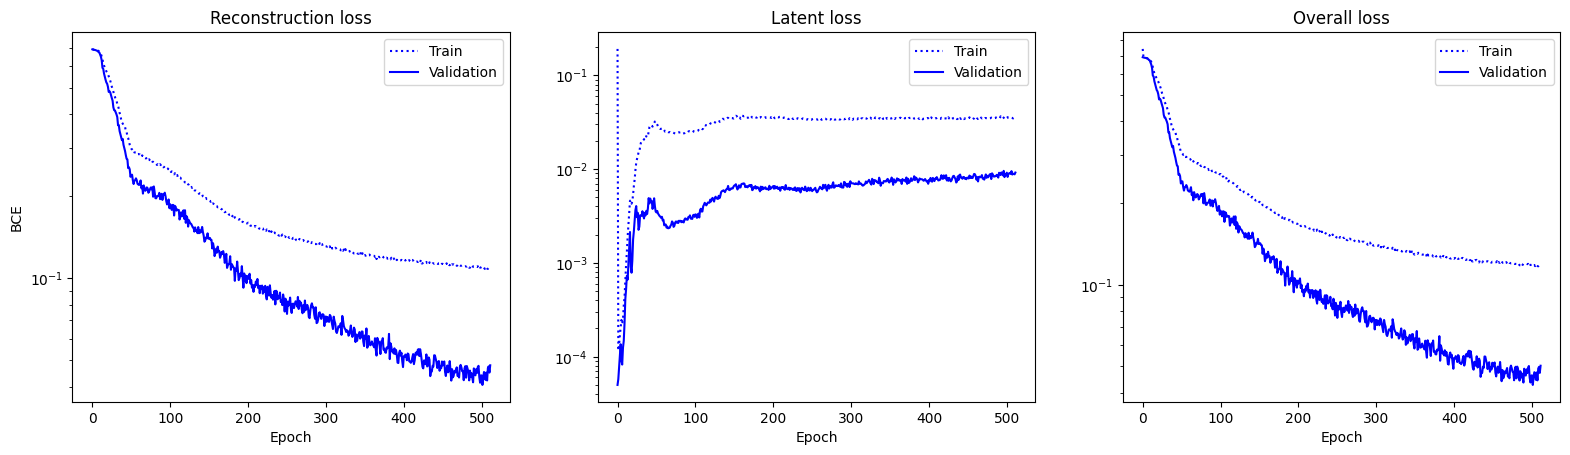

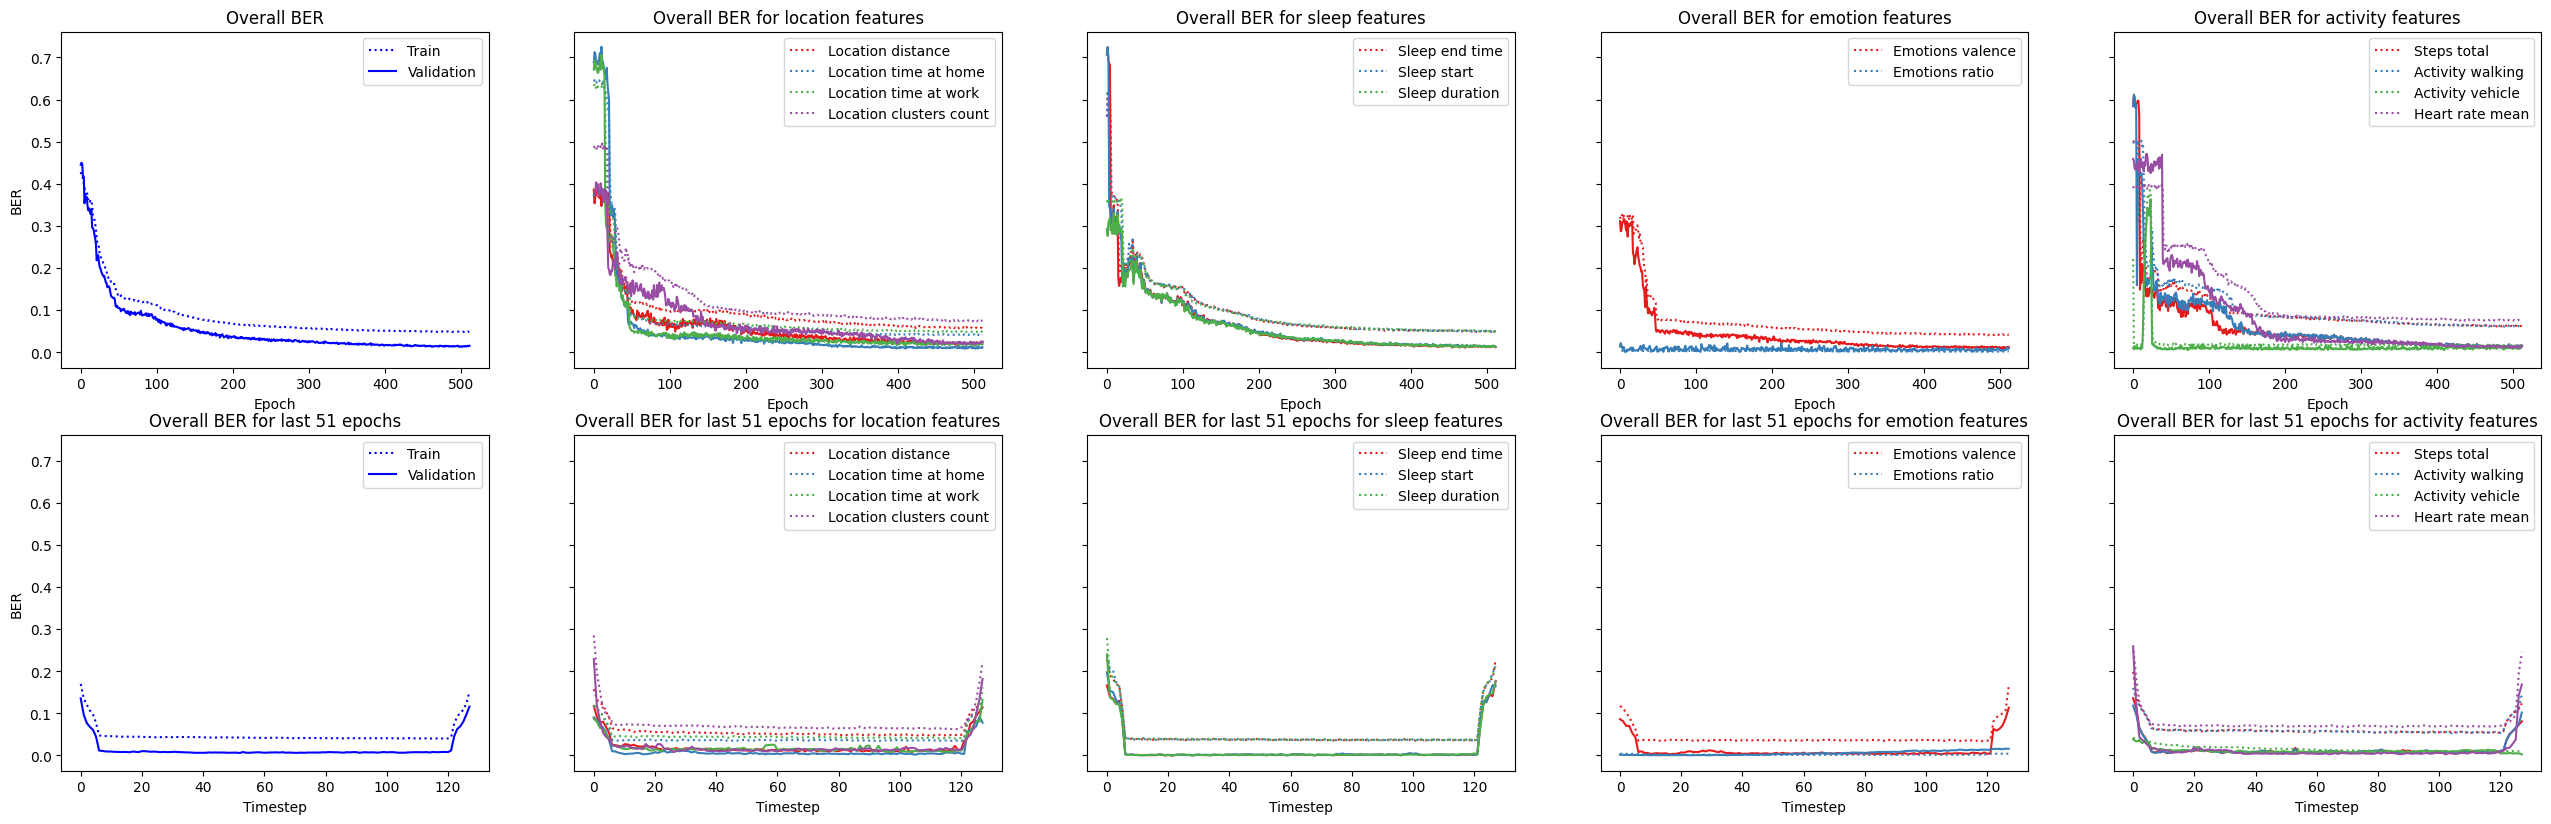

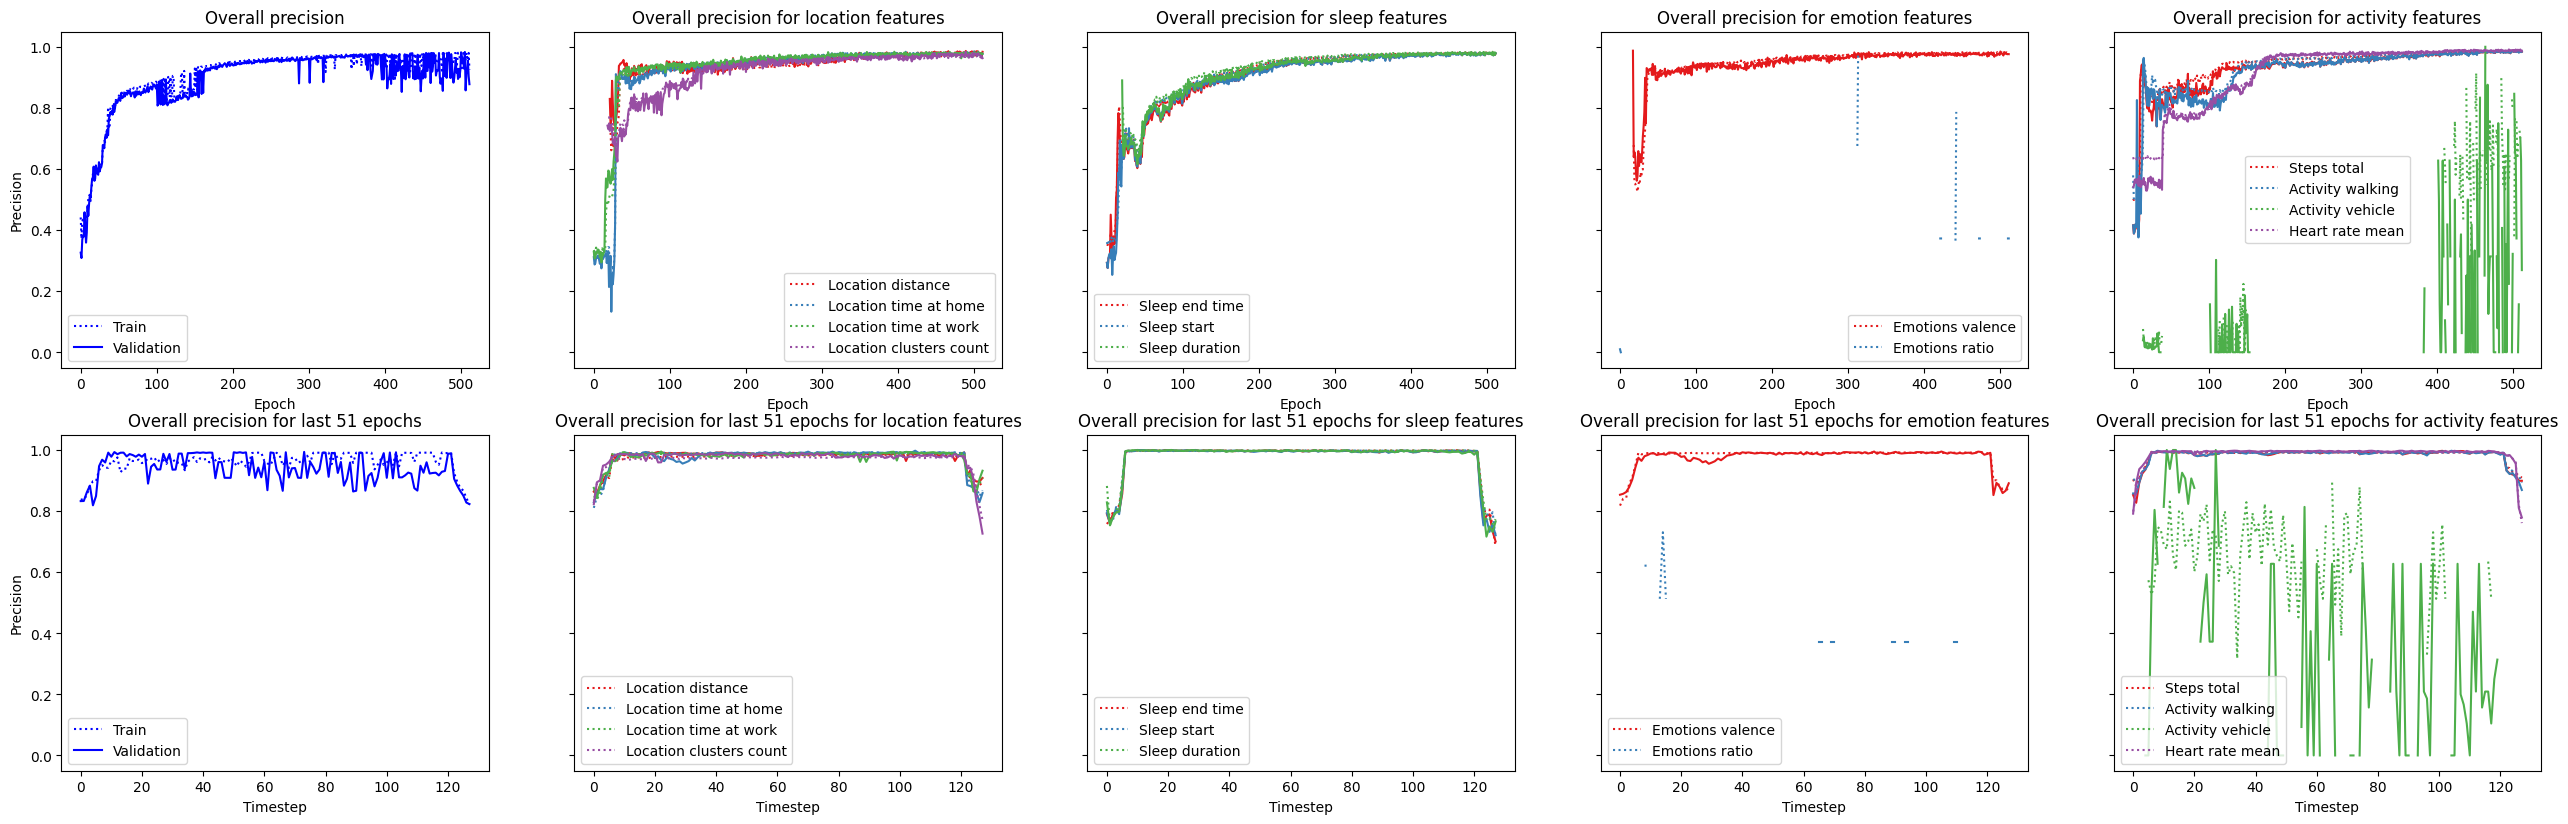

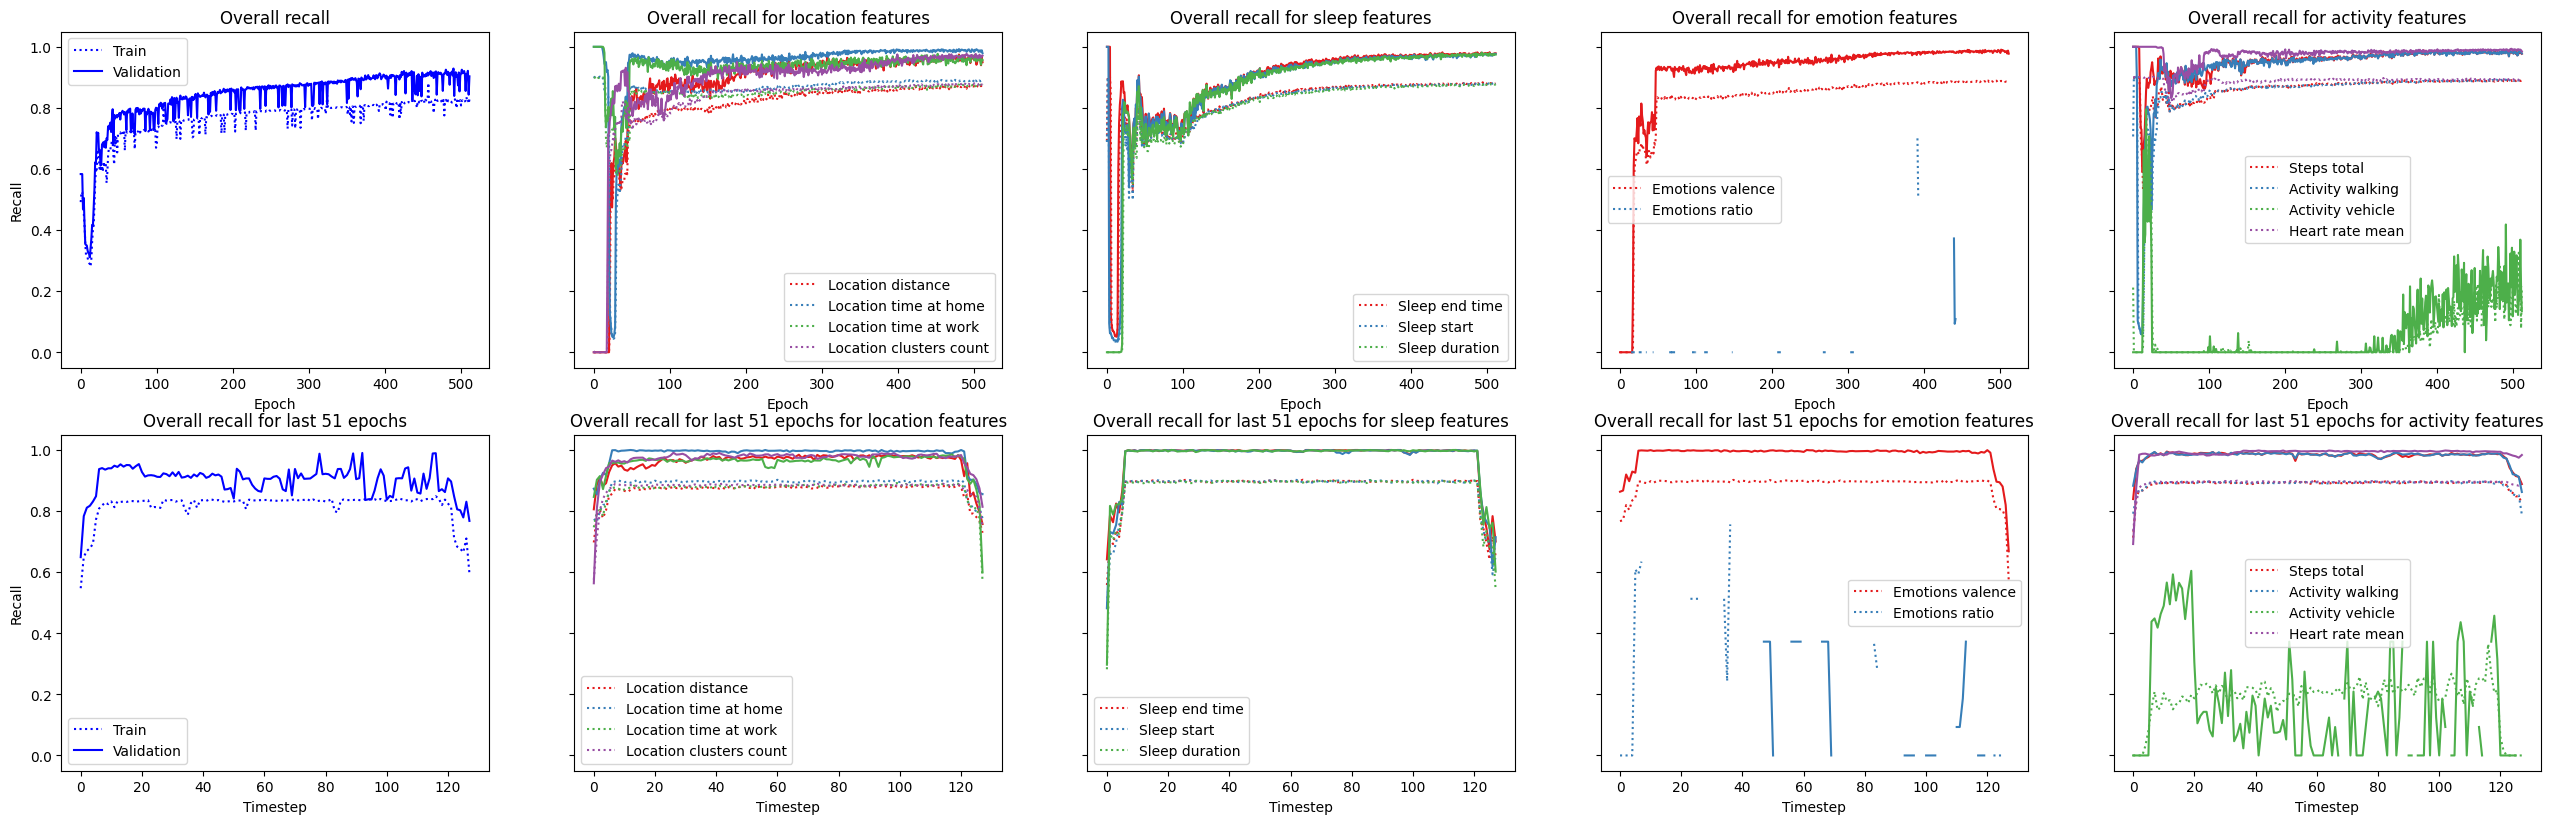

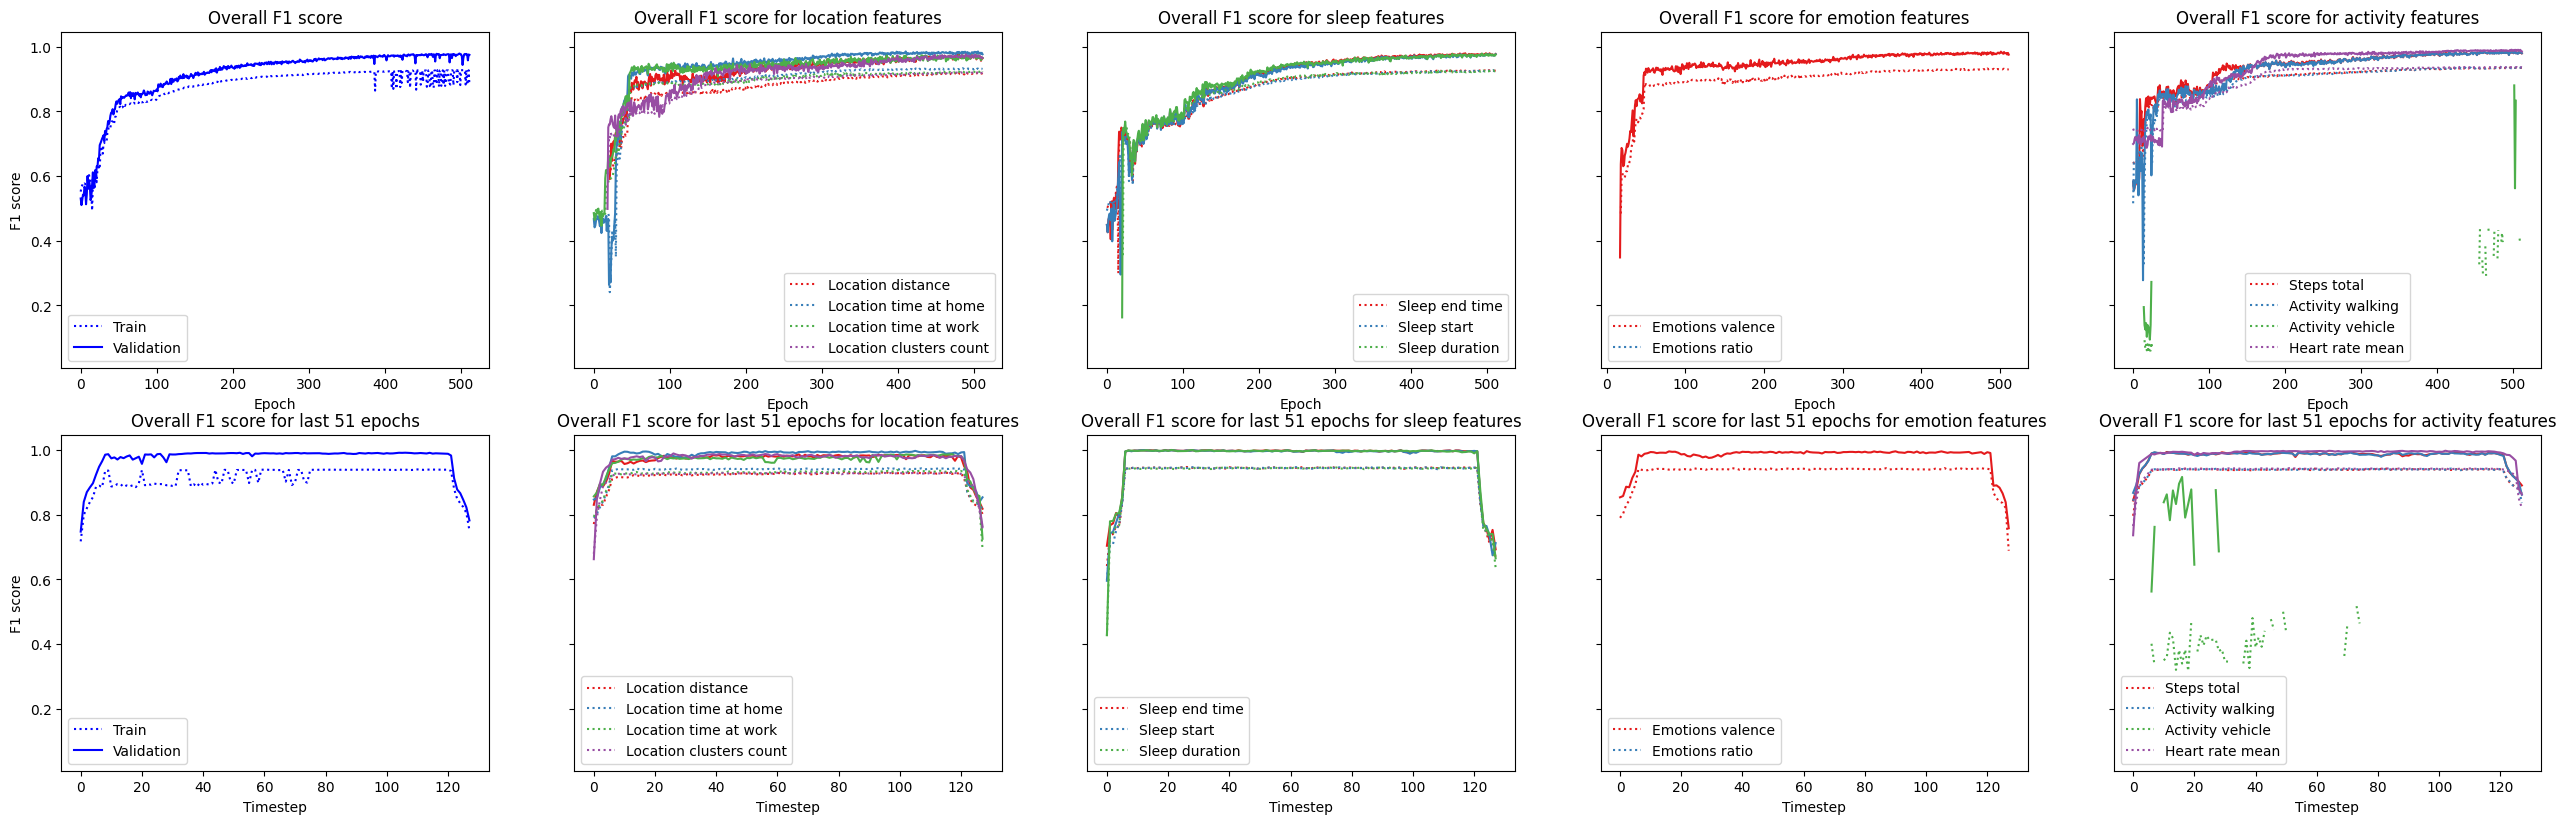

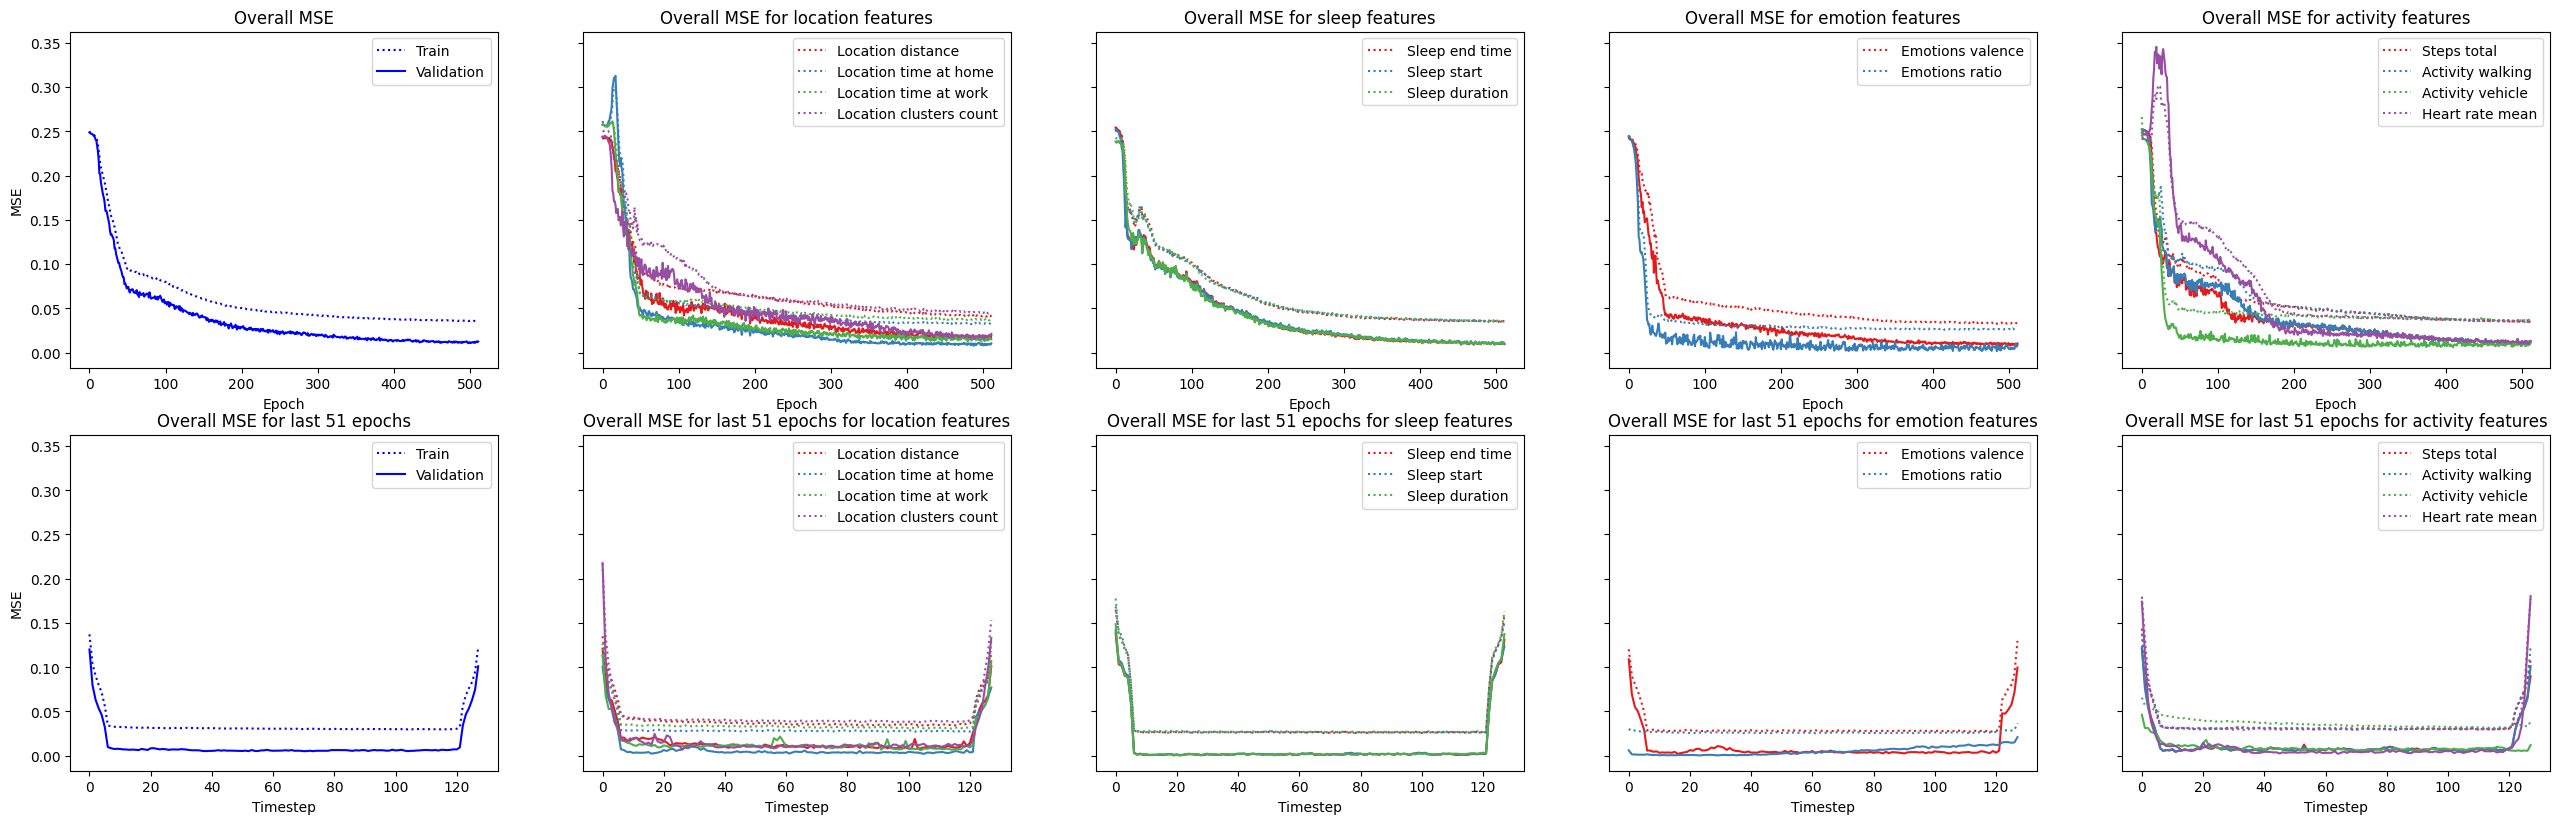

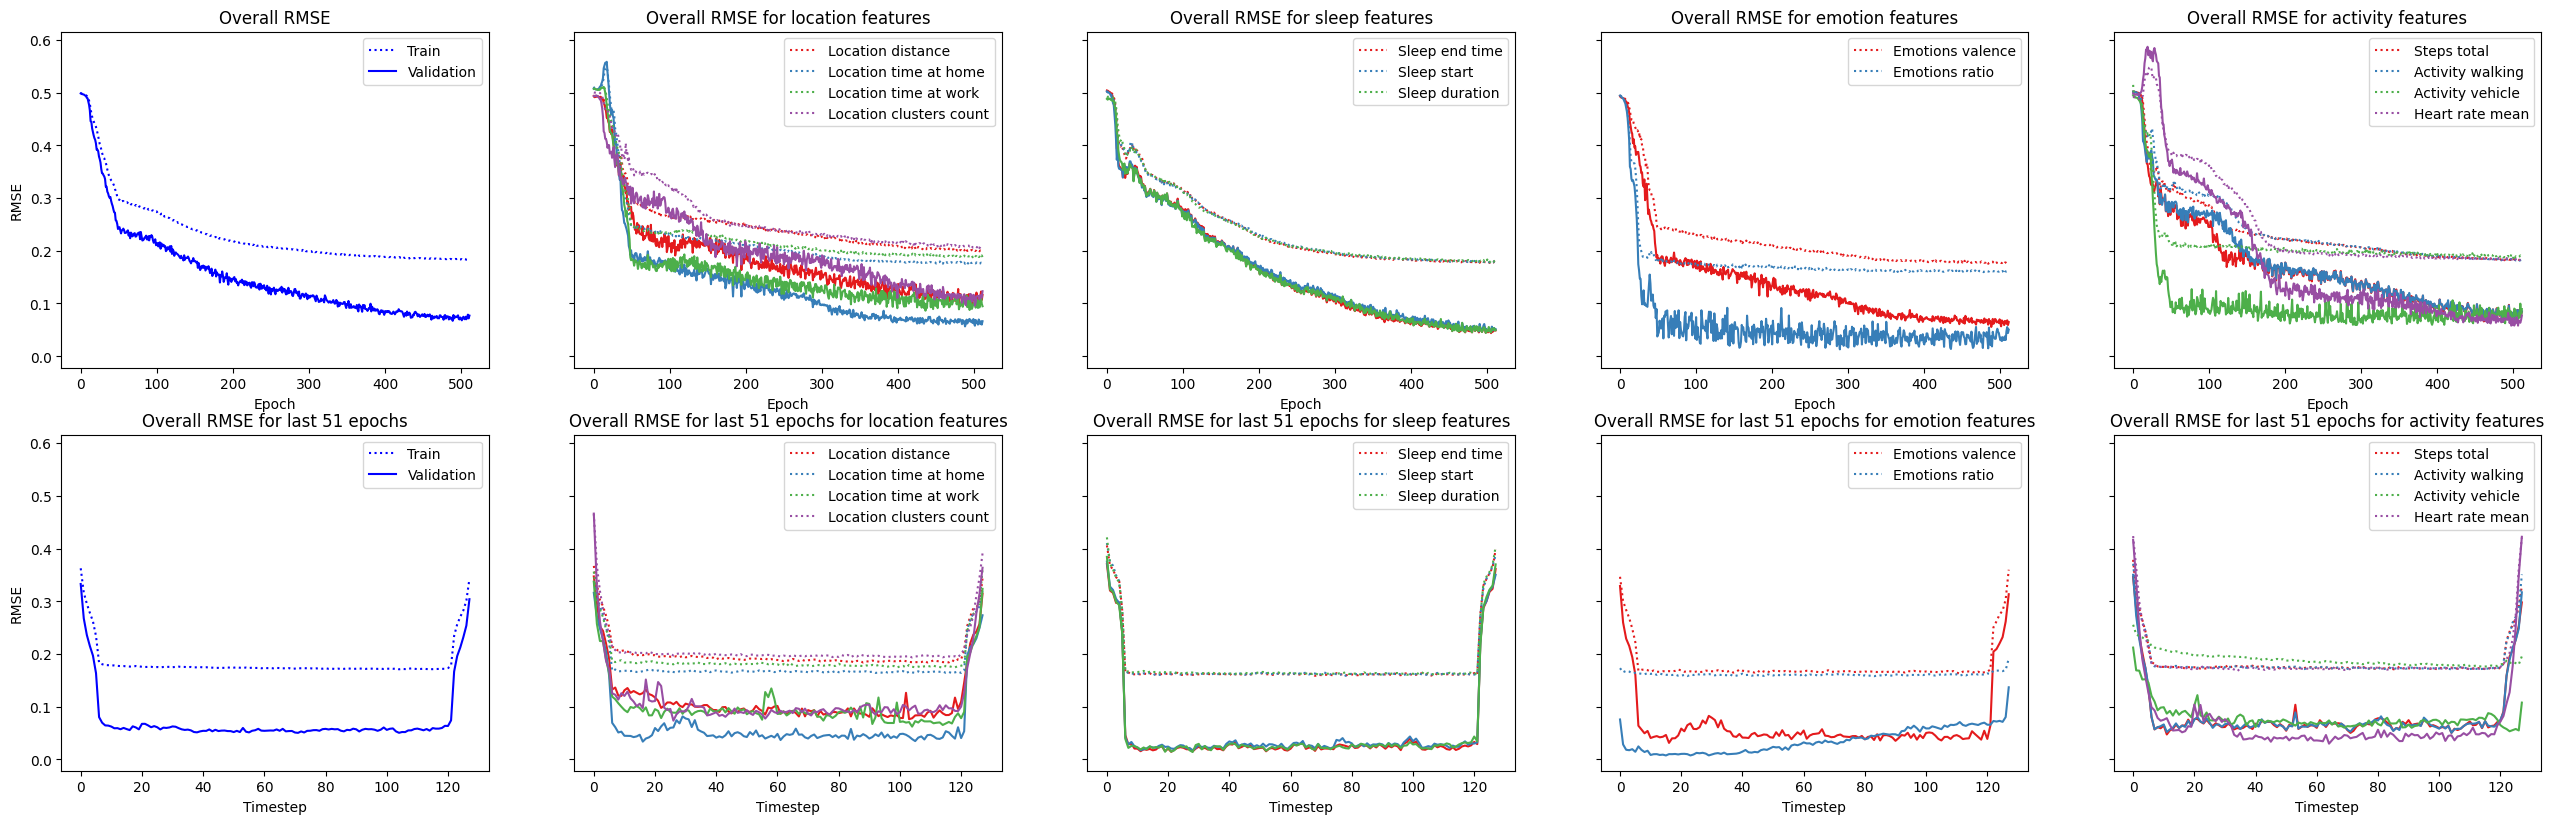

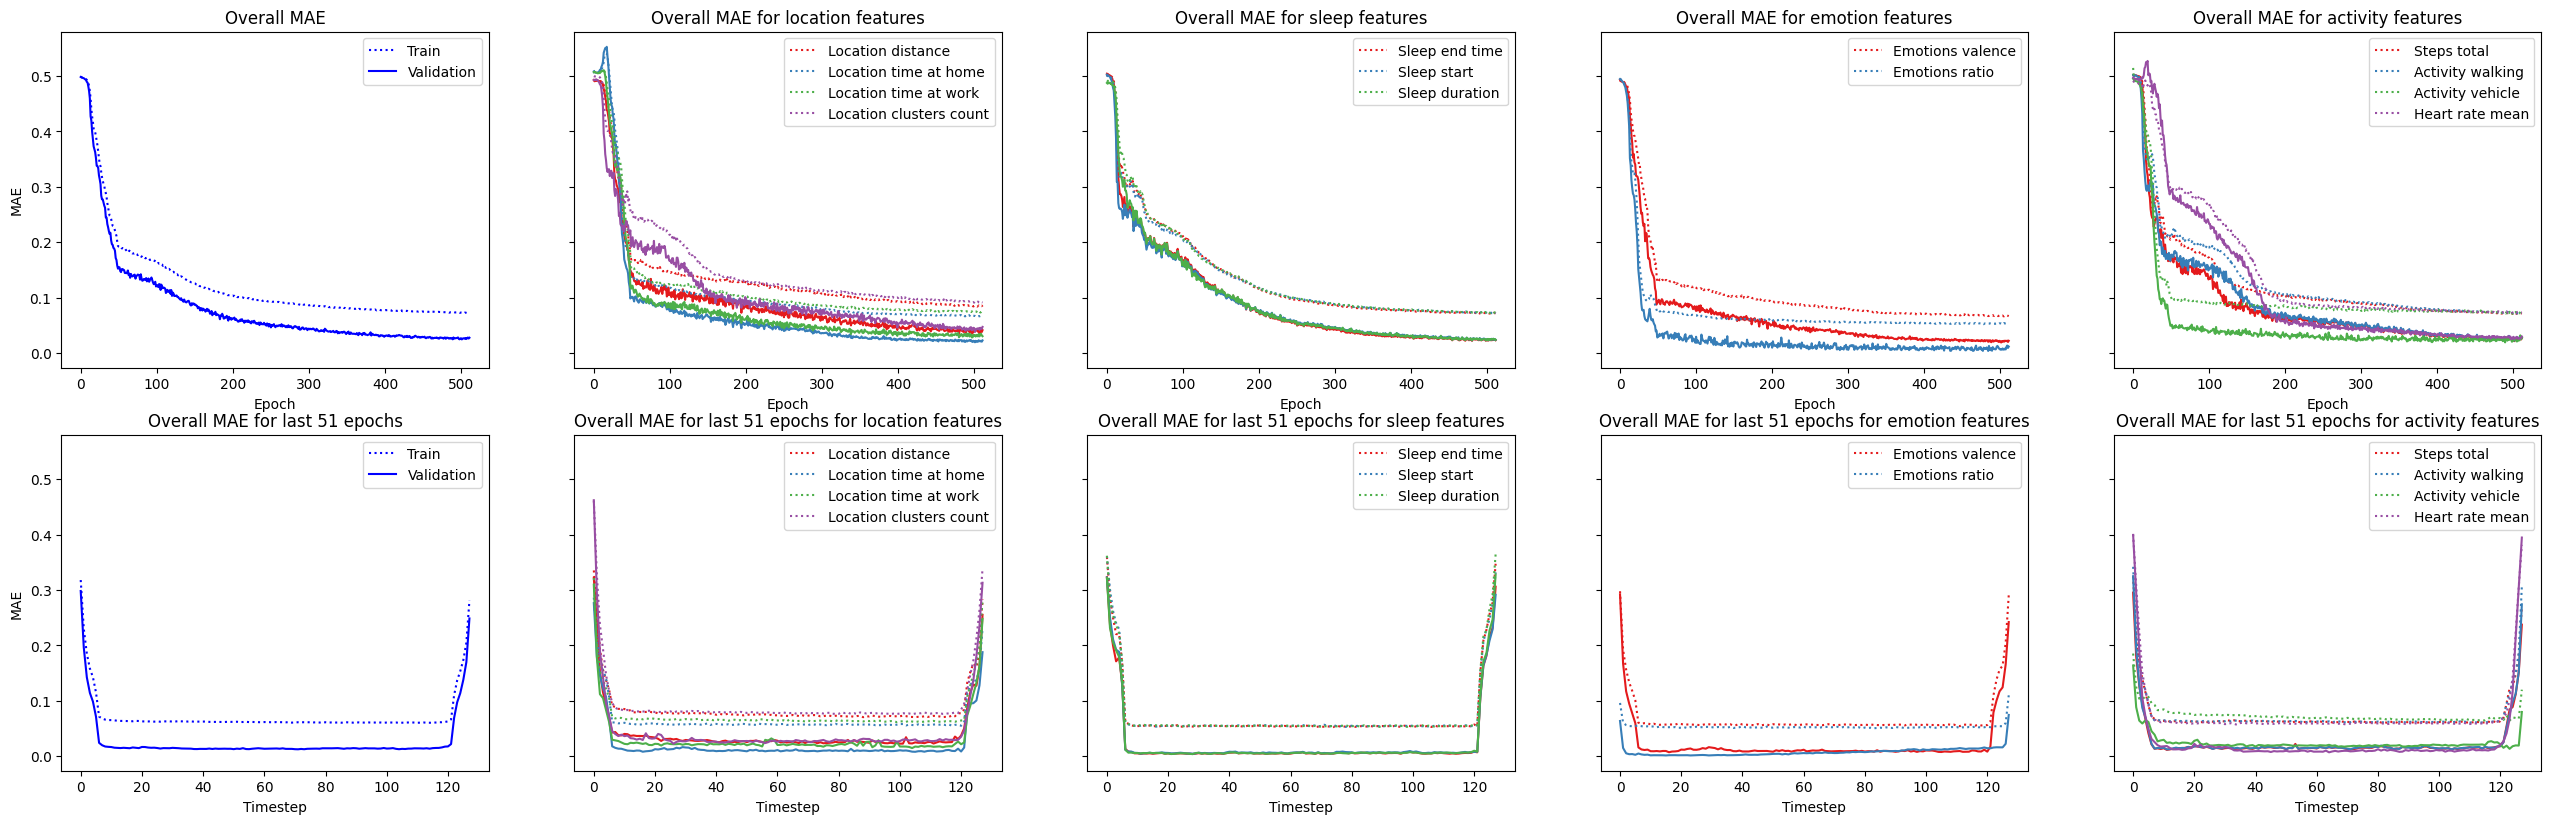

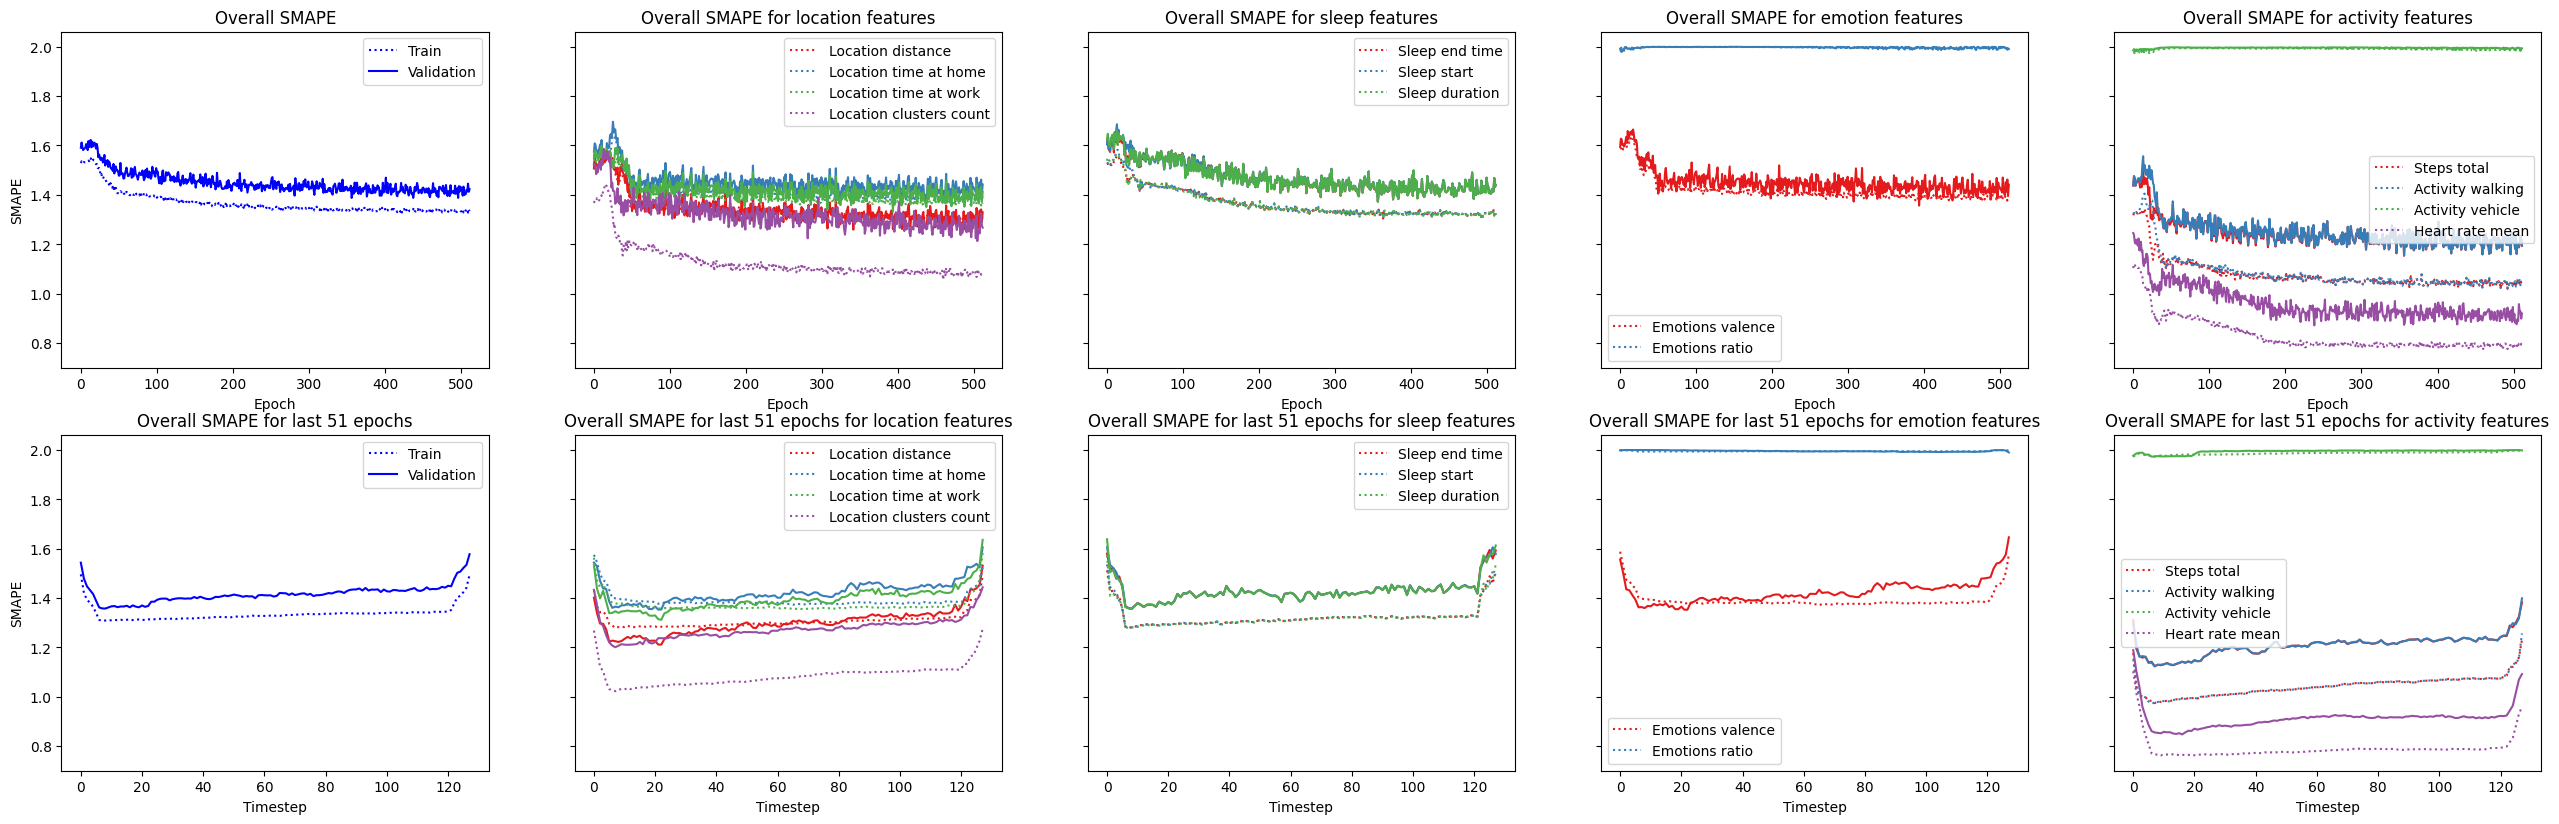

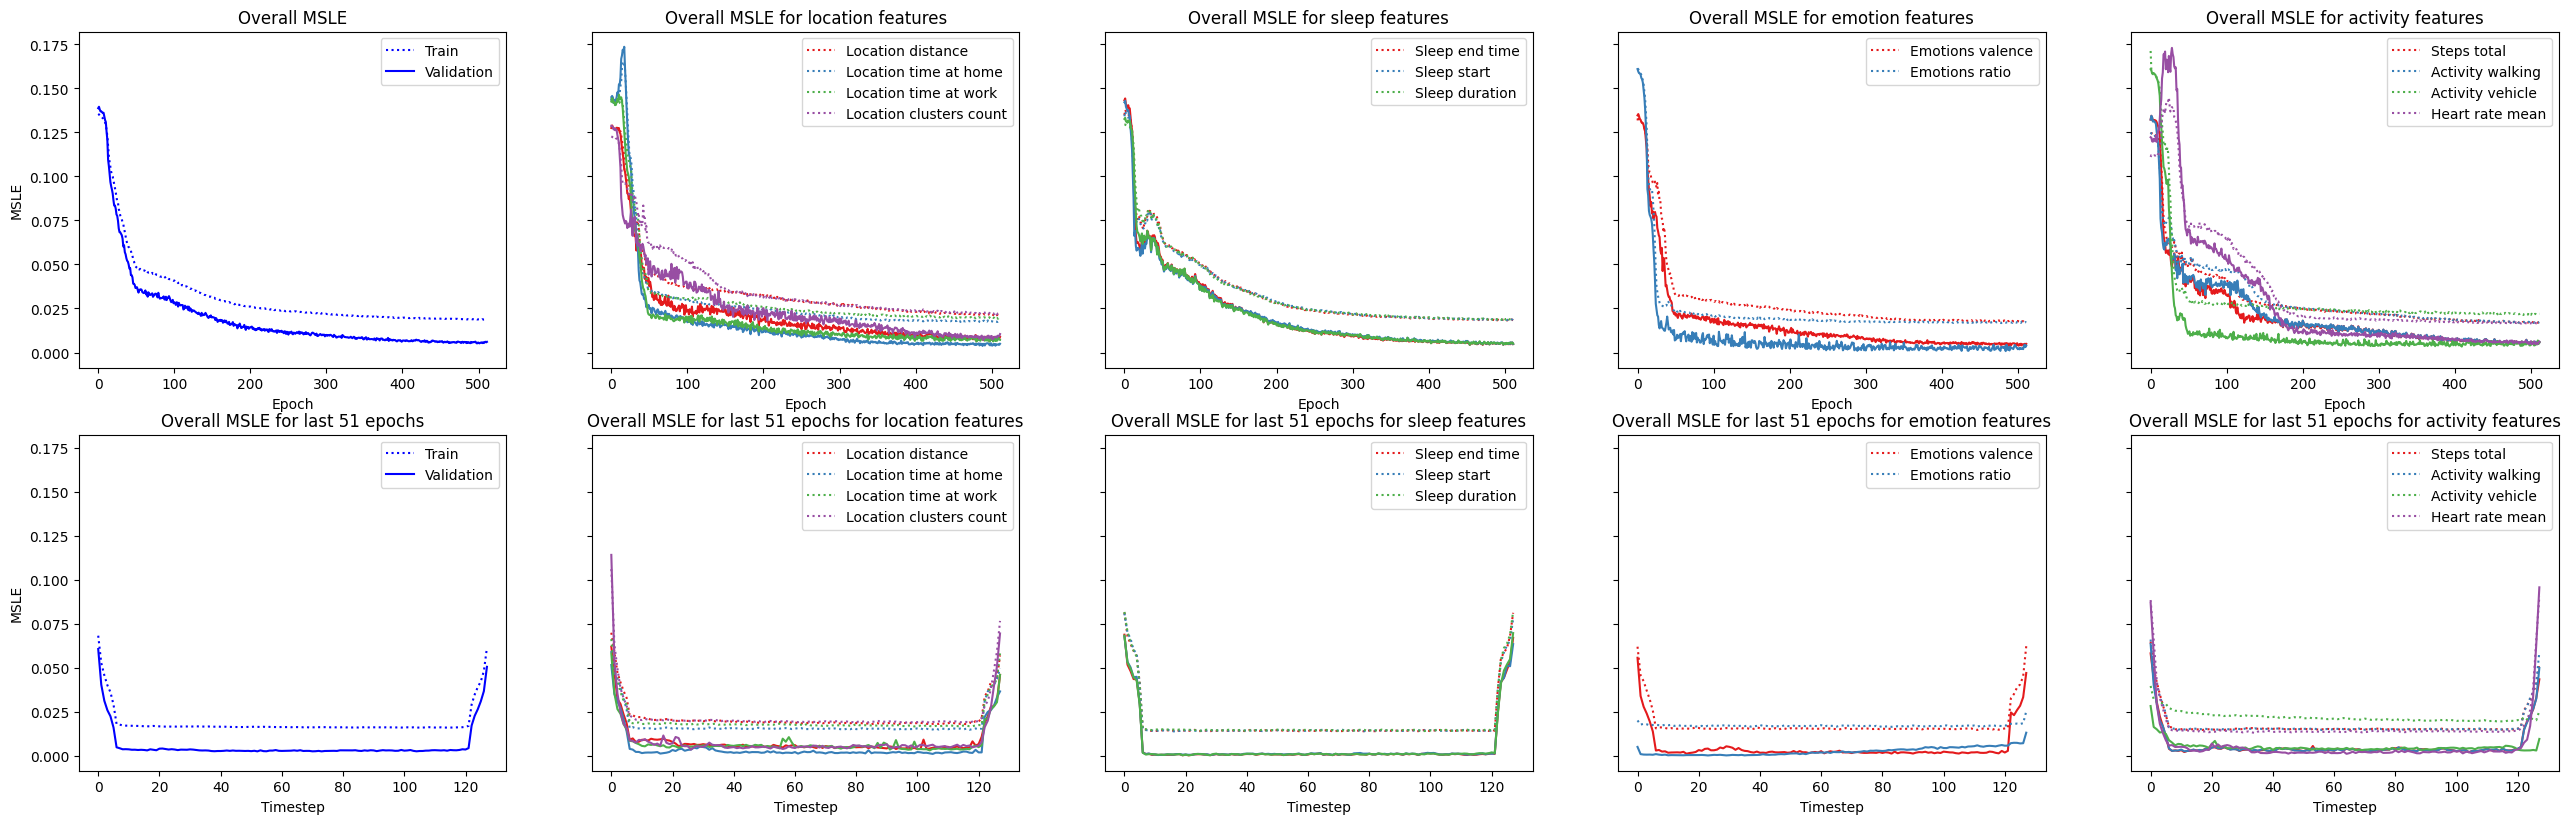

In [43]:
# Define feature names and feature gropus
feature_groups = {'location': [0, 5, 6, 7], 'sleep': [1, 2, 3], 'emotion': [4, 11], 'activity': [8, 9, 10, 12]}

# Compute latent forecasting length
output_length = output_lengths[-1]

# Display metric plots
plot_features(train_losses, val_losses, train_metrics, val_metrics,
              feature_metric_names, feature_names, feature_groups, last_epochs)

In [ ]:
class WNConv1d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size):
        super().__init__()

        # Define convolutional layer
        self.conv = nn.utils.weight_norm(
            nn.Conv1d(input_dim, output_dim, kernel_size))

    def forward(self, input):
        # Propagate input through convolutional layer
        x = self.conv(input)
        return x

def shift_right(input, size=1):
    return F.pad(input, [size, 0])[:, :, :input.shape[2]]

class CausalConv1d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size):
        super().__init__()

        # Define padding strategy
        pad = (kernel_size - 1, 0)
        self.pad = nn.ConstantPad1d(pad, 0)

        # Define convolutional layer
        self.conv = WNConv1d(input_dim, output_dim, kernel_size)

    def forward(self, input):
        # Pad input
        x = self.pad(input)

        # Forward input through layer
        x = self.conv(x)
        return x

class PixelBlock(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        # Define output layer
        self.output = WNConv1d(input_dim + 1, input_dim, 1)

    def forward(self, input, background, condition=None):
        # Propagate input and background trhough output layers
        x = input
        x = torch.cat([x, background], 1)
        x = self.output(x)
        return x

class PixelCNN(nn.Module):
    def __init__(self, output_length, num_embed, conv_dim, num_layers, kernel_size):
        super().__init__()
        # Initialize number of layers
        self.num_embed = num_embed

        # Convert even kernel size to odd
        if kernel_size % 2 == 0:
            kernel_size = kernel_size + 1

        # Define causal convolution
        self.causalconv = CausalConv1d(num_embed, conv_dim, kernel_size // 2)

        # Compute and register background
        coords = (torch.arange(output_length).float() - output_length / 2) / output_length
        coords = coords.view(1, 1, output_length).expand(1, 1, output_length)
        self.register_buffer('background', coords)

        # Define pixel block layers
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(
                PixelBlock(conv_dim))

        # Define output layers
        output = [nn.ELU(inplace=True), WNConv1d(conv_dim, num_embed, 1)]
        self.output = nn.Sequential(*output)

    def forward(self, input):
        # Get input dimensions
        batch, length = input.shape

        # One hot encode inputs into embeddings
        x = F.one_hot(input, self.num_embed).permute(0, 2, 1).type_as(self.background)

        # Run encodings through causal convolution
        x = shift_right(self.causalconv(x))

        # Resize background channel
        background = self.background.expand(batch, 1, length)

        # Forward input through layers
        for layer in self.layers:
            x = layer(x, background)

        # Forward input through output layers
        x = self.output(x)
        return x

In [ ]:
# Set VQ-VAE mododel to evaluation mode
vqvae.eval()

# Define model parameters
conv_dim = 64
num_layers = 4
kernel_size = 3

# Load model
pixelcnn = PixelCNN(output_length, num_embed, conv_dim, num_layers, kernel_size)
pixelcnn = pixelcnn.to(device)
print('Model definition:')
print(pixelcnn)

In [ ]:
def evaluate_latents(preds, labels, metric_names):
    try:
        preds = preds.detach()
        labels = labels.detach()
    except:
        pass
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    # Initialize arrays to store metrics
    num_metrics = len(metric_names)
    metrics = np.zeros((num_metrics,) + preds.shape[1:])

    # Compute metrics
    for index, metric_name in enumerate(metric_names):
        if metric_name == 'cer':
            # Compute bit error rate (BER)
            metric = (preds != labels).mean(0)
        elif metric_name == 'prec micro':
            # Compute micro-averaged precision
            prec_micro = np.array([mt.precision_score(labels[:, index], preds[:, index], average='micro') for index in range(labels.shape[1])])
            metric = prec_micro
        elif metric_name == 'prec macro':
            # Compute macro-averaged precision
            prec_macro = np.array([mt.precision_score(labels[:, index], preds[:, index], average='macro') for index in range(labels.shape[1])])
            metric = prec_macro
        elif metric_name == 'prec weighted':
            # Compute weight-averaged precision
            prec_weighted = np.array([mt.precision_score(labels[:, index], preds[:, index], average='weighted') for index in range(labels.shape[1])])
            metric = prec_weighted
        elif metric_name == 'recall micro':
            # Compute micro-averaged recall
            recall_micro = np.array([mt.recall_score(labels[:, index], preds[:, index], average='micro') for index in range(labels.shape[1])])
            metric = recall_micro
        elif metric_name == 'recall macro':
            # Compute macro-averaged precision
            recall_macro = np.array([mt.recall_score(labels[:, index], preds[:, index], average='macro') for index in range(labels.shape[1])])
            metric = recall_macro
        elif metric_name == 'recall weighted':
            # Compute weight-averaged precision
            recall_weighted = np.array([mt.recall_score(labels[:, index], preds[:, index], average='weighted') for index in range(labels.shape[1])])
            metric = recall_weighted
        elif metric_name == 'f1 micro':
            # Compute micro-averaged F1-score
            metric = 2 * prec_micro * recall_micro / (prec_micro + recall_micro)
        elif metric_name == 'f1 macro':
            # Compute macro-averaged F1-score
            metric = 2 * prec_macro * recall_macro / (prec_macro + recall_macro)
        elif metric_name == 'f1 weighted':
            # Compute weight-averaged F1-score
            metric = 2 * prec_weighted * recall_weighted / (prec_weighted + recall_weighted)

        # Store metrics
        metrics[index, :] = metric
    return metrics

def train_pixelcnn(model, vqvae, loaders, optimizer, scheduler, device, name,
                   num_epochs, last_epochs, feature_metric_names, latent_metric_names,
                   slice_length, output_length, num_features, checkpoint_path,
                   temperature):
    # Return model if already trained
    model_path = path.join(checkpoint_path, f'pixelcnn_{name}.pt')
    results_path = path.join(checkpoint_path, f'pixelcnn_{name}.pkl')
    if path.exists(model_path) and path.exists(results_path):
        best_model_weights = torch.load(model_path)
        model.load_state_dict(best_model_weights)
        with open(results_path, 'rb') as file:
            results = pickle.load(file)
        print('Model and results loaded')
        return (model,) + results

    # Start timer for training
    start = time.time()

    # Define loss criterion
    criterion = nn.CrossEntropyLoss()

    # Initialize losses
    best_loss = float('inf')
    train_losses = np.zeros(num_epochs)
    val_losses = np.zeros(num_epochs)

    # Initialize feature and latent metrics
    num_feature_metrics = len(feature_metric_names)
    num_latent_metrics = len(latent_metric_names)
    train_feature_metrics = np.zeros((num_epochs, num_feature_metrics, num_features, slice_length))
    val_feature_metrics = np.zeros((num_epochs, num_feature_metrics, num_features, slice_length))
    train_latent_metrics = np.zeros((num_epochs, num_latent_metrics, output_length))
    val_latent_metrics = np.zeros((num_epochs, num_latent_metrics, output_length))
    train_future_feature_metrics = np.zeros((num_epochs, num_feature_metrics, num_features, slice_length))
    val_future_feature_metrics = np.zeros((num_epochs, num_feature_metrics, num_features, slice_length))
    train_future_latent_metrics = np.zeros((num_epochs, num_latent_metrics, output_length))
    val_future_latent_metrics = np.zeros((num_epochs, num_latent_metrics, output_length))

    # Define training phases
    phases = ('train', 'val')

    # Train model for given number of epochs
    for epoch in range(num_epochs):
        # Get mask sample
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 15)

        # Execute for each training phase
        for phase in phases:
            training = phase == 'train'
            if training:
                model.train()
            else:
                model.eval()

            # Initialize running losses, metrics, and data size
            running_loss = 0
            running_feature_metrics = np.zeros((num_feature_metrics, num_features, slice_length))
            running_latent_metrics = np.zeros((num_latent_metrics, output_length))
            running_future_feature_metrics = np.zeros((num_feature_metrics, num_features, slice_length))
            running_future_latent_metrics = np.zeros((num_latent_metrics, output_length))
            data_size = 0

            # Iterate over batches of images
            for sample in loaders[phase]:
                # Set gradients to zero
                optimizer.zero_grad()

                # Get batch inputs and labels
                feature_inputs = sample['input']['mask'].to(device).float()
                future_feature_inputs = sample['future']['mask'].to(device).float()
                feature_labels = feature_inputs
                future_feature_labels = future_feature_inputs

                # Get model outputs and backpropagate losses
                with torch.set_grad_enabled(training):
                    _, _, latent_inputs = vqvae.encode(feature_inputs)
                    _, _, future_latent_labels = vqvae.encode(future_feature_inputs)
                    latent_labels = latent_inputs
                    latent_outputs = model(latent_inputs)

                    # Sample consecutive latent sequence
                    model.eval()
                    future_latent_inputs = torch.cat([latent_inputs,
                                                      torch.zeros(latent_inputs.size(), dtype=torch.int64).to(device)], 1)
                    for start in range(1, output_length+1):
                        end = start + output_length
                        outputs = model(future_latent_inputs[:, start:end])
                        probs = torch.softmax(outputs[:, :, -1] / temperature, 1)
                        future_latent_inputs[:, end-1] = torch.multinomial(probs, 1).squeeze(-1)
                    if trainining: model.eval()

                    # Compute discrete sequences
                    _, latent_preds = latent_outputs.max(1)
                    future_latent_preds = future_latent_inputs[:, start:]

                    # Decode latent sequence
                    feature_outputs = vqvae.decode_code(latent_preds)
                    future_feature_outputs = vqvae.decode_code(future_latent_preds)

                    # Compute metrics
                    feature_metrics = evaluate_features(feature_outputs, feature_labels, feature_metric_names)
                    future_feature_metrics = evaluate_features(future_feature_outputs, future_feature_labels, feature_metric_names)
                    latent_metrics = evaluate_latents(latent_preds, latent_labels, latent_metric_names)
                    future_latent_metrics = evaluate_latents(future_latent_preds, future_latent_labels, latent_metric_names)

                    # Compute loss
                    loss = criterion(latent_outputs, latent_labels)

                    # Propagate loss backward
                    if training:
                        loss.backward()
                        optimizer.step()

                # Accumulate running losses, metrics, and data size
                batch_size = feature_inputs.size(0)
                running_loss += loss.item() * batch_size
                running_feature_metrics += feature_metrics * batch_size
                running_latent_metrics += latent_metrics * batch_size
                running_future_feature_metrics += future_feature_metrics * batch_size
                running_future_latent_metrics += future_latent_metrics * batch_size
                data_size += batch_size

            # Update learning rate scheduler
            scheduler.step()

            # Compute latent, reconstruction and overall loss
            mean_loss = running_loss / data_size
            mean_feature_metrics = running_feature_metrics / data_size
            mean_latent_metrics = running_latent_metrics / data_size
            mean_future_feature_metrics = running_future_feature_metrics / data_size
            mean_future_latent_metrics = running_future_latent_metrics / data_size

            if training:
                train_losses[epoch] = mean_loss
                train_feature_metrics[epoch, :, :, :] = mean_feature_metrics
                train_latent_metrics[epoch, :, :] = mean_latent_metrics
                train_future_feature_metrics[epoch, :, :, :] = mean_future_feature_metrics
                train_future_latent_metrics[epoch, :, :] = mean_future_latent_metrics
            else:
                val_losses[epoch] = mean_loss
                val_feature_metrics[epoch, :, :, :] = mean_feature_metrics
                val_latent_metrics[epoch, :, :] = mean_latent_metrics
                val_future_feature_metrics[epoch, :, :, :] = mean_future_feature_metrics
                val_future_latent_metrics[epoch, :, :] = mean_future_latent_metrics

            # Display epoch statistics
            print(f'[{phase}]'.rjust(10) + f'   <loss> {mean_loss:.4f}')
            print('(features)')
            for index, metric_name in enumerate(feature_metric_names):
                print(f'{" " * 10}{f"<{metric_name}>".rjust(9)} reco: {np.nanmean(mean_feature_metrics[index, :, :]):.4f} | fore: {np.nanmean(mean_future_feature_metrics[index, :, :]):.4f}')
            print('(latents)')
            for index, metric_name in enumerate(latent_metric_names):
                print(f'{" " * 2}{f"<{metric_name}>".rjust(17)} reco: {np.nanmean(mean_latent_metrics[index, :]):.4f} | fore: {np.nanmean(mean_future_latent_metrics[index, :]):.4f}')

            # Deep copy best model weights
            if not training:
                if mean_loss < best_loss:
                    best_loss = mean_loss
                    best_feature_metrics = mean_feature_metrics
                    best_latent_metrics = mean_latent_metrics
                    best_future_feature_metrics = mean_future_feature_metrics
                    best_future_latent_metrics = mean_future_latent_metrics
                    best_epoch = epoch
                    best_model_weights = copy.deepcopy(model.state_dict())

    # Display training statistics
    elapsed = time.time() - start
    print(f'Training complete in {elapsed//60:.0f} min {elapsed%60:.0f} s')
    print(f'Best model in epoch {str(best_epoch+1).ljust(3)} [val]    <loss> {best_loss:.4f}')
    print('(features)')
    for index, metric_name in enumerate(feature_metric_names):
        print(f'{" " * 29}{f"<{metric_name}>".rjust(9)} reco: {np.nanmean(best_feature_metrics[index, :, :]):.4f} | fore: {np.nanmean(best_future_feature_metrics[index, :, :]):.4f}')
    print('(latents)')
    for index, metric_name in enumerate(latent_metric_names):
        print(f'{" " * 21}{f"<{metric_name}>".rjust(17)} reco: {np.nanmean(best_latent_metrics[index, :]):.4f} | fore: {np.nanmean(best_future_latent_metrics[index, :]):.4f}')

    print(f'Model in last {str(last_epochs).ljust(2)} epochs  [val]   <loss> {val_losses[-last_epochs:].mean():.4f}')
    print('(features)')
    for index, metric_name in enumerate(feature_metric_names):
        print(f'{" " * 30}{f"<{metric_name}>".rjust(9)} reco: {np.nanmean(val_feature_metrics[-last_epochs:, index, :, :]):.4f} | fore: {np.nanmean(val_future_feature_metrics[-last_epochs:, index, :, :]):.4f}')
    print('(latents)')
    for index, metric_name in enumerate(latent_metric_names):
        print(f'{" " * 22}{f"<{metric_name}>".rjust(17)} reco: {np.nanmean(val_latent_metrics[-last_epochs:, index, :]):.4f} | fore: {np.nanmean(val_future_latent_metrics[-last_epochs:, index, :]):.4f}')

    # Save best model, losses and metrics
    model.load_state_dict(best_model_weights)
    torch.save(model.state_dict(), model_path)
    with open(results_path, 'wb') as file:
        results = (train_losses, val_losses,
                   train_feature_metrics, val_feature_metrics,
                   train_latent_metrics, val_latent_metrics,
                   train_future_feature_metrics, val_future_feature_metrics,
                   train_future_latent_metrics, val_future_latent_metrics)
        pickle.dump(results, file)
    return (model,) + results

In [ ]:
# Define optimizer and learning rate scheduler parameters
num_epochs = 2
step_size = 512
gamma = 1

# Define optimizer and learning rate scheduler
lr = 1e-3
n_iter = len(loaders['train']) * num_epochs
optimizer = optim.Adam(pixelcnn.parameters(), lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma)

# Define training parameters
last_epochs = round(num_epochs * .1)
latent_metric_names = {'cer': 'CER',
                       'prec micro': 'precision (micro)', 'prec macro': 'precision (macro)', 'prec weighted': 'precision (weighted)',
                       'recall micro': 'recall (micro)', 'recall macro': 'recall (macro)', 'recall weighted': 'recall (weighted)',
                       'f1 micro': 'F1 score (micro)', 'f1 macro': 'F1 score (macro)', 'f1 weighted': 'F1 score (weighted)',}

# Define evaluation parameters
temperature = 1

# Train model for given number of epochs
print(f'Model name: {name}')
print(f'''Dataset properties:
Model architecture:
- conv_dim:    {conv_dim}
- kernel_size: {kernel_size}
- num_layers:  {num_layers}
Optimizer properties:
- lr:        {lr}
- step_size: {step_size}
- gamma:     {gamma}''')
(pixelcnn,
 train_losses, val_losses,
 train_feature_metrics, val_feature_metrics,
 train_latent_metrics, val_latent_metrics,
 train_future_feature_metrics, val_future_feature_metrics,
 train_future_latent_metrics, val_future_latent_metrics) = train_pixelcnn(
    pixelcnn, vqvae, loaders, optimizer, scheduler, device, name,
    num_epochs, last_epochs, feature_metric_names, latent_metric_names,
    slice_length, output_length, num_features, checkpoint_path,
    temperature)

In [ ]:
def plot_latents(train_losses, val_losses, train_metrics, val_metrics,
                 metric_names, last_epochs, losses=True):

    if losses:
        # Plot loss evolution across epochs
        plt.figure(figsize=(6.4, 4.8))
        plt.plot(train_losses, 'b:', label='Train')
        plt.plot(val_losses, 'b', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('CE')
        plt.title('Cross-entropy loss')
        plt.yscale('log')
        plt.legend()

    # Define analysis dimensions
    dimensions = ('epoch', 'timestep')

    # Display plot for each metric
    for index, metric_name in enumerate(metric_names, start=1):
        figure, axes = plt.subplots(1, 2, figsize=(12.8, 4.8), sharey=True)

        # Get corresponding values for metric
        train_metric = train_metrics[:, index-1, :]
        val_metric = val_metrics[:, index-1, :]
        metric_label = metric_names[metric_name]
        metric_title = metric_label if metric_label == metric_label.upper() else metric_label.capitalize()

        # Analyze performanc: across epochs and along forecasting time
        for row, dimension in enumerate(dimensions):
            # Analyze across epochs
            if dimension == 'epoch':
                # Aggregate metrics along timesteps
                mean_train_metric = np.nanmean(train_metric, 1)
                mean_val_metric = np.nanmean(val_metric, 1)
            elif dimension == 'timestep':
                # Aggregate metrics along features
                mean_train_metric = np.nanmean(train_metric[-last_epochs:, :], 0).T
                mean_val_metric = np.nanmean(val_metric[-last_epochs:, :], 0).T

            # Plot overall metric evolution
            axis = axes[row]
            axis.plot(mean_train_metric, 'b:', label=f'Train')
            axis.plot(mean_val_metric, 'b', label=f'Validation')
            dimension_label = dimension.capitalize()
            axis.set_xlabel(dimension_label)
            axis.set_ylabel(metric_title)
            title = f'Overall {metric_label}' + ('' if dimension == 'epoch' else f' for last {last_epochs} epochs')
            axis.set_title(title)
            axis.legend()

In [ ]:
# Display latent metrics plots
plot_latents(train_losses, val_losses, train_latent_metrics, val_latent_metrics,
             latent_metric_names, last_epochs)
plot_latents(train_losses, val_losses, train_future_latent_metrics, val_future_latent_metrics,
             latent_metric_names, last_epochs, False)

# Display features metrics plots
plot_features(train_losses, val_losses, train_feature_metrics, val_feature_metrics,
              feature_metric_names, feature_names, feature_groups, last_epochs, False)
plot_features(train_losses, val_losses, train_future_feature_metrics, val_future_feature_metrics,
              feature_metric_names, feature_names, feature_groups, last_epochs, False)